In [11]:
!pip install opencv-python

In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import pickle
import copy
from sklearn.preprocessing import normalize

In [17]:
# myImg = cv2.imread("data/oldImgs/11001002702/building_0.tif",cv2.IMREAD_UNCHANGED)
# print(type(myImg))

myImg = plt.imread("USGSImageryWMS.jpg")
print(myImg)

OSError: cannot identify image file 'USGSImageryWMS.jpg'

In [13]:
cd ~/Documents/git_nhts_cnn_auto/data/newImgs/36053030600


/home/ubuntu/Documents/git_nhts_cnn_auto/data/newImgs/36053030600


In [15]:
# predict car ownership as the first step.
# need to change it to the online version.
### TO-DO: Figure out how to read and save data online.
# df_nhts = pd.read_csv("../data/raw/data_input_V1.csv")
# df_loc = pd.read_csv("../data/raw/hhct.csv")
###
df_nhts = pd.read_csv("data/data_input_V1.csv")
df_loc = pd.read_csv("data/hhct.csv")
# drop one col
df_loc.drop('HHSTFIPS', axis = 1, inplace = True)

In [16]:
for i in range(len(df_nhts.columns)):
    print(df_nhts.columns[i])
print(df_nhts.columns)
print(df_loc.columns) # the HHCT is the census tract information.
print("HOUSEID" in df_nhts.columns) # Use HOUSEID to connect the two datasets.

CDIVMSAR
CENSUS_D
CENSUS_R
DRIVER
DRVRCNT
ENDTIME
EDUC
GASPRICE
HBHTNRNT
HBHUR
HBPPOPDN
HBRESDN
HHFAMINC
HHSIZE
HHSTATE
HHSTFIPS
HHVEHCNT
HH_CBSA
HH_HISP
HH_RACE
HOMEOWN
HOUSEID
HTEEMPDN
LIF_CYC
MSACAT
MSASIZE
NONHHCNT
NUMADLT
NUMONTRP
PERSONID
PRMACT
RAIL
R_AGE
R_AGE_IMP
R_SEX
R_SEX_IMP
STRTTIME
TDAYDATE
TDCASEID
TDWKND
TRAVDAY
TRIPPURP
TRPACCMP
TRPHHACC
TRPMILES
TRPTRANS
TRVLCMIN
URBAN
URBANSIZE
URBRUR
WHYFROM
WHYTO
WHYTRP1S
WHYTRP90
WORKER
WRKCOUNT
WTTRDFIN
ALT_16
ALT_23
ALT_45
BIKE4EX
BIKESHARE
BIKE_DFR
BIKE_GKP
BORNINUS
CARSHARE
CNTTDTR
CONDNIGH
CONDPUB
CONDRIDE
CONDRIVE
CONDSPEC
CONDTAX
CONDTRAV
DELIVER
DIARY
DISTTOSC17
DISTTOWK17
FLEXTIME
FRSTHM17
GCDWORK
GT1JBLWK
HEALTH
HHRESP
LPACT
MCUSED
MEDCOND
MEDCOND6
NBIKETRP
NOCONG
NWALKTRP
OCCAT
PAYPROF
PHYACT
PTUSED
RIDESHARE
SAMEPLC
SCHTRN1
SCHTRN2
SCHTYP
TIMETOWK
VPACT
WALK4EX
WALK_DEF
WALK_GKQ
WKFMHMXX
WKFTPT
WKRMHM
WKSTFIPS
WRKTIME
WRKTRANS
WRK_HOME
WTPERFIN
YEARMILE
YRTOUS
BIKE
BIKE2SAVE
BUS
CAR
CNTTDHH
PARA
PC
PLACE
PRICE
PTRANS


In [17]:
# augment HHCT to df_nhts
df = pd.merge(df_nhts, df_loc, on = 'HOUSEID')

### combine the columns to create an identifier to match the folder names.
# HHSTFIPS: 2 digits; HHCNTYFP: 3 digits; HHCT: 6 digits. add zeros.
# turn to strings
df['HHSTFIPS'] = df['HHSTFIPS'].astype(np.str)
df['HHCNTYFP'] = df['HHCNTYFP'].astype(np.str)
df['HHCT'] = df['HHCT'].astype(np.str)
# HHSTFIPS
df['HHSTFIPS'].loc[df['HHSTFIPS'].str.len() == 1, ] = '0' + df['HHSTFIPS'].loc[df['HHSTFIPS'].str.len() == 1, ]
# HHCNTYFP
for i in range(2): # 2 = 3-1
    augmented_zero_str = '0' * (i+1)
    df['HHCNTYFP'].loc[df['HHCNTYFP'].str.len() == 2-i, ] = augmented_zero_str + df['HHCNTYFP'].loc[df['HHCNTYFP'].str.len() == 2-i, ]
# HHCT
for i in range(5): # 5 = 6-1
    augmented_zero_str = '0' * (i+1)
    df['HHCT'].loc[df['HHCT'].str.len() == 5-i, ] = augmented_zero_str + df['HHCT'].loc[df['HHCT'].str.len() == 5-i, ]
# Create the census tract identifier
df['CENSUS_ID'] = df['HHSTFIPS'] + df['HHCNTYFP'] + df['HHCT']


/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [18]:
print(df['CENSUS_ID'])
# choose several variables for preprocessing.
# col 0 is the HHID; col 1 is the CENSUS_ID.

input_var = ['HOUSEID', 'CENSUS_ID', 
             'WRKCOUNT', 'DRVRCNT', 'HHSIZE', 'HOMEOWN', 
             'MSASIZE', 'URBRUR','HHFAMINC','CNTTDHH', 'HBHTNRNT', 'HBPPOPDN', 
             'HBRESDN', 'HH_HISP', 'HH_RACE', 'LIF_CYC', 'MSACAT', 'NUMADLT', 
             'URBAN', 'URBANSIZE', 'CENSUS_D', 'CENSUS_R', 'DRIVER', 'EDUC']

input_var_short = ['WRKCOUNT', 'DRVRCNT', 'HHSIZE', 'HOMEOWN', 
                   'MSASIZE', 'URBRUR','HHFAMINC', 'CNTTDHH', 'HBHTNRNT', 'HBPPOPDN', 
                   'HBRESDN', 'HH_HISP', 'HH_RACE', 'LIF_CYC', 'MSACAT', 'NUMADLT', 
                   'URBAN', 'URBANSIZE', 'CENSUS_D', 'CENSUS_R', 'DRIVER', 'EDUC'] 
# input_var = ['HOUSEID', 'CENSUS_ID', 'WRKCOUNT', 'DRVRCNT', 'HHSIZE', 'HOMEOWN', 
#              'MSASIZE', 'URBRUR','HHFAMINC']
# input_var_short = ['WRKCOUNT', 'DRVRCNT', 'HHSIZE', 'HOMEOWN', 
#              'MSASIZE', 'URBRUR','HHFAMINC'] 
num_inputs = len(input_var_short)
output_var = ['HHVEHCNT']
print(df[input_var_short].head())

0         37191001301
1         37191001301
2         37191001301
3         37191001301
4         37191001301
5         37191001301
6         55109120202
7         55109120202
8         36001001500
9         36001001500
10        36001001500
11        36001001500
12        36001001500
13        36001001500
14        36001001500
15        36001001500
16        36001001500
17        24043011202
18        24043011202
19        24043011202
20        24043011202
21        55025002302
22        55025002302
23        55025002302
24        55025002302
25        55025002302
26        55025002302
27        55025002302
28        55025002302
29        55025002302
             ...     
781801    48085031636
781802    48085031636
781803    48085031636
781804    48085031636
781805    48113008200
781806    48113008200
781807    48113008200
781808    48113008200
781809    48113008200
781810    48113008200
781811    06053011900
781812    06053011900
781813    37193961200
781814    37193961200
781815    

In [19]:
# edit values.
df.loc[:, input_var_short] = normalize(df[input_var_short])
y_index = df.loc[:, output_var] > 3
df.loc[y_index.iloc[:,0].values, output_var] = 3
print(df.loc[:, input_var].head(10))
print(df.loc[:, output_var].head(10))

    HOUSEID    CENSUS_ID  WRKCOUNT   DRVRCNT    HHSIZE   HOMEOWN   MSASIZE  \
0  30000007  37191001301  0.001237  0.003712  0.003712  0.001237  0.001237   
1  30000007  37191001301  0.001237  0.003712  0.003712  0.001237  0.001237   
2  30000007  37191001301  0.001237  0.003712  0.003712  0.001237  0.001237   
3  30000007  37191001301  0.001237  0.003712  0.003712  0.001237  0.001237   
4  30000007  37191001301  0.001237  0.003712  0.003712  0.001237  0.001237   
5  30000007  37191001301  0.001237  0.003712  0.003712  0.001237  0.001237   
6  30000008  55109120202  0.004711  0.004711  0.004711  0.002355  0.011777   
7  30000008  55109120202  0.004711  0.004711  0.004711  0.002355  0.011777   
8  30000012  36001001500  0.000054  0.000054  0.000054  0.000054  0.000163   
9  30000012  36001001500  0.000054  0.000054  0.000054  0.000054  0.000163   

     URBRUR  HHFAMINC   CNTTDHH  ...   HH_RACE   LIF_CYC    MSACAT   NUMADLT  \
0  0.001237  0.008661  0.007424  ...  0.002475  0.012373  0.0

In [20]:
#### TO-DO: remove or impute missing values of x.

### match the NHTS and image census IDs.
root_name = 'data/oldImgs/'
dir_names = os.listdir(root_name)
standard_file_name_list = ['road_0.tif', 'road_1.tif', 'building_0.tif', 'building_1.tif']
num_channels = len(standard_file_name_list)
# replace old keys (sometimes 10 digits) by new keys (11 digits)
old_keys = pd.Series(dir_names).astype(np.str)
new_keys = copy.copy(old_keys)
new_keys[old_keys.str.len()==10]='0'+old_keys[old_keys.str.len() == 10]
# find the matching keys.
image_keys_list = list(new_keys)
nhts_keys_list = list(df['CENSUS_ID'])
shared_keys_list = list(set(nhts_keys_list) & set(image_keys_list))
# Use this following df_intersect...
df_intersect = pd.merge(df, pd.Series(shared_keys_list, name = 'CENSUS_ID'), how = 'inner', on = 'CENSUS_ID')
### Notes:
    # There are many keys...
    # old_keys: folder names
    # new_keys: "0" + folder names for those with 10 digits
    # NHTS keys: the keys in NHTS datasets

### read images based on the order in df_intersect
folder_new_id_list = list(df_intersect.CENSUS_ID)
folder_old_id_list = []
for id_ in folder_new_id_list:
    if id_[0] == '0':
        folder_old_id_list.append(id_[1:])
    else:
        folder_old_id_list.append(id_) # match up to the folder names...

In [21]:
file_size = (200, 200) # Use a smaller size of images...Otherwise the laptop cannot work at a certain point.
# TO-DO: Figure out how to run a full size image.
print(len(folder_old_id_list))
image_array = np.zeros((len(folder_old_id_list), num_channels, file_size[0], file_size[1])) # default: black images
# read the images
for folder_name_idx in np.arange(len(folder_old_id_list)):
    if folder_name_idx%100==0:
        print(folder_name_idx)
    for file_name_idx in np.arange(len(standard_file_name_list)):
        full_file_name = root_name+folder_old_id_list[folder_name_idx]+'/'+standard_file_name_list[file_name_idx]
        #print(full_file_name)
        img = cv2.imread(full_file_name, cv2.IMREAD_UNCHANGED)
        if img is None:
            print("wtf")
            pass # default is black images...so when images do not exist. Keep the zeros
        else:
            image_array[folder_name_idx, file_name_idx, :, :] = cv2.resize(img, file_size).astype(np.uint8)
            print(full_file_name)



4445
0
data/oldImgs/5059020400/road_0.tif
wtf
wtf
wtf
data/oldImgs/5059020400/road_0.tif
wtf
wtf
wtf
data/oldImgs/5059020400/road_0.tif
wtf
wtf
wtf
data/oldImgs/5059020400/road_0.tif
wtf
wtf
wtf
data/oldImgs/5059020400/road_0.tif
wtf
wtf
wtf
data/oldImgs/5059020400/road_0.tif
wtf
wtf
wtf
data/oldImgs/5059020400/road_0.tif
wtf
wtf
wtf
data/oldImgs/5059020400/road_0.tif
wtf
wtf
wtf
data/oldImgs/5059020400/road_0.tif
wtf
wtf
wtf
data/oldImgs/5059020400/road_0.tif
wtf
wtf
wtf
data/oldImgs/5059020400/road_0.tif
wtf
wtf
wtf
data/oldImgs/5059020400/road_0.tif
wtf
wtf
wtf
data/oldImgs/5059020400/road_0.tif
wtf
wtf
wtf
data/oldImgs/5059020400/road_0.tif
wtf
wtf
wtf
data/oldImgs/5059020400/road_0.tif
wtf
wtf
wtf
data/oldImgs/5107480200/road_0.tif
wtf
wtf
wtf
data/oldImgs/5107480200/road_0.tif
wtf
wtf
wtf
data/oldImgs/5107480200/road_0.tif
wtf
wtf
wtf
data/oldImgs/5107480200/road_0.tif
wtf
wtf
wtf
data/oldImgs/5107480200/road_0.tif
wtf
wtf
wtf
data/oldImgs/5107480200/road_0.tif
wtf
wtf
wtf
data/o

data/oldImgs/38017010108/road_0.tif
data/oldImgs/38017010108/road_1.tif
data/oldImgs/38017010108/building_0.tif
data/oldImgs/38017010108/building_1.tif
data/oldImgs/38017010108/road_0.tif
data/oldImgs/38017010108/road_1.tif
data/oldImgs/38017010108/building_0.tif
data/oldImgs/38017010108/building_1.tif
data/oldImgs/38017010108/road_0.tif
data/oldImgs/38017010108/road_1.tif
data/oldImgs/38017010108/building_0.tif
data/oldImgs/38017010108/building_1.tif
data/oldImgs/38017010108/road_0.tif
data/oldImgs/38017010108/road_1.tif
data/oldImgs/38017010108/building_0.tif
data/oldImgs/38017010108/building_1.tif
data/oldImgs/38017010108/road_0.tif
data/oldImgs/38017010108/road_1.tif
data/oldImgs/38017010108/building_0.tif
data/oldImgs/38017010108/building_1.tif
data/oldImgs/38017010108/road_0.tif
data/oldImgs/38017010108/road_1.tif
data/oldImgs/38017010108/building_0.tif
data/oldImgs/38017010108/building_1.tif
data/oldImgs/38017010108/road_0.tif
data/oldImgs/38017010108/road_1.tif
data/oldImgs/380

data/oldImgs/11001005500/road_0.tif
data/oldImgs/11001005500/road_1.tif
data/oldImgs/11001005500/building_0.tif
data/oldImgs/11001005500/building_1.tif
data/oldImgs/11001005500/road_0.tif
data/oldImgs/11001005500/road_1.tif
data/oldImgs/11001005500/building_0.tif
data/oldImgs/11001005500/building_1.tif
data/oldImgs/11001005500/road_0.tif
data/oldImgs/11001005500/road_1.tif
data/oldImgs/11001005500/building_0.tif
data/oldImgs/11001005500/building_1.tif
data/oldImgs/11001005500/road_0.tif
data/oldImgs/11001005500/road_1.tif
data/oldImgs/11001005500/building_0.tif
data/oldImgs/11001005500/building_1.tif
data/oldImgs/11001005500/road_0.tif
data/oldImgs/11001005500/road_1.tif
data/oldImgs/11001005500/building_0.tif
data/oldImgs/11001005500/building_1.tif
data/oldImgs/11001005500/road_0.tif
data/oldImgs/11001005500/road_1.tif
data/oldImgs/11001005500/building_0.tif
data/oldImgs/11001005500/building_1.tif
data/oldImgs/11001005500/road_0.tif
data/oldImgs/11001005500/road_1.tif
data/oldImgs/110

data/oldImgs/38015010400/road_0.tif
data/oldImgs/38015010400/road_1.tif
data/oldImgs/38015010400/building_0.tif
data/oldImgs/38015010400/building_1.tif
data/oldImgs/38015010400/road_0.tif
data/oldImgs/38015010400/road_1.tif
data/oldImgs/38015010400/building_0.tif
data/oldImgs/38015010400/building_1.tif
data/oldImgs/38015010400/road_0.tif
data/oldImgs/38015010400/road_1.tif
data/oldImgs/38015010400/building_0.tif
data/oldImgs/38015010400/building_1.tif
200
data/oldImgs/38015010400/road_0.tif
data/oldImgs/38015010400/road_1.tif
data/oldImgs/38015010400/building_0.tif
data/oldImgs/38015010400/building_1.tif
data/oldImgs/38015010400/road_0.tif
data/oldImgs/38015010400/road_1.tif
data/oldImgs/38015010400/building_0.tif
data/oldImgs/38015010400/building_1.tif
data/oldImgs/38015010400/road_0.tif
data/oldImgs/38015010400/road_1.tif
data/oldImgs/38015010400/building_0.tif
data/oldImgs/38015010400/building_1.tif
data/oldImgs/38015010400/road_0.tif
data/oldImgs/38015010400/road_1.tif
data/oldImgs

data/oldImgs/11001009904/road_0.tif
data/oldImgs/11001009904/road_1.tif
data/oldImgs/11001009904/building_0.tif
data/oldImgs/11001009904/building_1.tif
data/oldImgs/11001009904/road_0.tif
data/oldImgs/11001009904/road_1.tif
data/oldImgs/11001009904/building_0.tif
data/oldImgs/11001009904/building_1.tif
data/oldImgs/11001009904/road_0.tif
data/oldImgs/11001009904/road_1.tif
data/oldImgs/11001009904/building_0.tif
data/oldImgs/11001009904/building_1.tif
data/oldImgs/11001009904/road_0.tif
data/oldImgs/11001009904/road_1.tif
data/oldImgs/11001009904/building_0.tif
data/oldImgs/11001009904/building_1.tif
data/oldImgs/11001009904/road_0.tif
data/oldImgs/11001009904/road_1.tif
data/oldImgs/11001009904/building_0.tif
data/oldImgs/11001009904/building_1.tif
data/oldImgs/11001009904/road_0.tif
data/oldImgs/11001009904/road_1.tif
data/oldImgs/11001009904/building_0.tif
data/oldImgs/11001009904/building_1.tif
data/oldImgs/38015011001/road_0.tif
data/oldImgs/38015011001/road_1.tif
data/oldImgs/380

data/oldImgs/11001005002/building_1.tif
data/oldImgs/11001005002/road_0.tif
data/oldImgs/11001005002/road_1.tif
data/oldImgs/11001005002/building_0.tif
data/oldImgs/11001005002/building_1.tif
data/oldImgs/11001005002/road_0.tif
data/oldImgs/11001005002/road_1.tif
data/oldImgs/11001005002/building_0.tif
data/oldImgs/11001005002/building_1.tif
data/oldImgs/11001005002/road_0.tif
data/oldImgs/11001005002/road_1.tif
data/oldImgs/11001005002/building_0.tif
data/oldImgs/11001005002/building_1.tif
data/oldImgs/11001005002/road_0.tif
data/oldImgs/11001005002/road_1.tif
data/oldImgs/11001005002/building_0.tif
data/oldImgs/11001005002/building_1.tif
data/oldImgs/11001003800/road_0.tif
data/oldImgs/11001003800/road_1.tif
data/oldImgs/11001003800/building_0.tif
data/oldImgs/11001003800/building_1.tif
data/oldImgs/11001003800/road_0.tif
data/oldImgs/11001003800/road_1.tif
data/oldImgs/11001003800/building_0.tif
data/oldImgs/11001003800/building_1.tif
data/oldImgs/11001003800/road_0.tif
data/oldImgs

data/oldImgs/5007021405/road_0.tif
data/oldImgs/5007021405/road_1.tif
data/oldImgs/5007021405/building_0.tif
data/oldImgs/5007021405/building_1.tif
data/oldImgs/5007021405/road_0.tif
data/oldImgs/5007021405/road_1.tif
data/oldImgs/5007021405/building_0.tif
data/oldImgs/5007021405/building_1.tif
data/oldImgs/5007021405/road_0.tif
data/oldImgs/5007021405/road_1.tif
data/oldImgs/5007021405/building_0.tif
data/oldImgs/5007021405/building_1.tif
data/oldImgs/5007021405/road_0.tif
data/oldImgs/5007021405/road_1.tif
data/oldImgs/5007021405/building_0.tif
data/oldImgs/5007021405/building_1.tif
data/oldImgs/5007021405/road_0.tif
data/oldImgs/5007021405/road_1.tif
data/oldImgs/5007021405/building_0.tif
data/oldImgs/5007021405/building_1.tif
data/oldImgs/11001008001/road_0.tif
data/oldImgs/11001008001/road_1.tif
data/oldImgs/11001008001/building_0.tif
data/oldImgs/11001008001/building_1.tif
data/oldImgs/11001008001/road_0.tif
data/oldImgs/11001008001/road_1.tif
data/oldImgs/11001008001/building_0.

data/oldImgs/5119004104/road_1.tif
data/oldImgs/5119004104/building_0.tif
data/oldImgs/5119004104/building_1.tif
data/oldImgs/5119004104/road_0.tif
data/oldImgs/5119004104/road_1.tif
data/oldImgs/5119004104/building_0.tif
data/oldImgs/5119004104/building_1.tif
data/oldImgs/5119004104/road_0.tif
data/oldImgs/5119004104/road_1.tif
data/oldImgs/5119004104/building_0.tif
data/oldImgs/5119004104/building_1.tif
data/oldImgs/5119004104/road_0.tif
data/oldImgs/5119004104/road_1.tif
data/oldImgs/5119004104/building_0.tif
data/oldImgs/5119004104/building_1.tif
data/oldImgs/5119004104/road_0.tif
data/oldImgs/5119004104/road_1.tif
data/oldImgs/5119004104/building_0.tif
data/oldImgs/5119004104/building_1.tif
data/oldImgs/5143010503/road_0.tif
data/oldImgs/5143010503/road_1.tif
data/oldImgs/5143010503/building_0.tif
data/oldImgs/5143010503/building_1.tif
data/oldImgs/5143010503/road_0.tif
data/oldImgs/5143010503/road_1.tif
data/oldImgs/5143010503/building_0.tif
data/oldImgs/5143010503/building_1.tif

data/oldImgs/11001002202/road_0.tif
data/oldImgs/11001002202/road_1.tif
data/oldImgs/11001002202/building_0.tif
data/oldImgs/11001002202/building_1.tif
data/oldImgs/11001002202/road_0.tif
data/oldImgs/11001002202/road_1.tif
data/oldImgs/11001002202/building_0.tif
data/oldImgs/11001002202/building_1.tif
data/oldImgs/11001002202/road_0.tif
data/oldImgs/11001002202/road_1.tif
data/oldImgs/11001002202/building_0.tif
data/oldImgs/11001002202/building_1.tif
data/oldImgs/11001002202/road_0.tif
data/oldImgs/11001002202/road_1.tif
data/oldImgs/11001002202/building_0.tif
data/oldImgs/11001002202/building_1.tif
data/oldImgs/11001002202/road_0.tif
data/oldImgs/11001002202/road_1.tif
data/oldImgs/11001002202/building_0.tif
data/oldImgs/11001002202/building_1.tif
data/oldImgs/38059020200/road_0.tif
wtf
wtf
data/oldImgs/38059020200/building_1.tif
data/oldImgs/38059020200/road_0.tif
wtf
wtf
data/oldImgs/38059020200/building_1.tif
data/oldImgs/38059020200/road_0.tif
wtf
wtf
data/oldImgs/38059020200/bui

data/oldImgs/11001009508/building_1.tif
data/oldImgs/11001009508/road_0.tif
data/oldImgs/11001009508/road_1.tif
data/oldImgs/11001009508/building_0.tif
data/oldImgs/11001009508/building_1.tif
data/oldImgs/11001009508/road_0.tif
data/oldImgs/11001009508/road_1.tif
data/oldImgs/11001009508/building_0.tif
data/oldImgs/11001009508/building_1.tif
data/oldImgs/11001008302/road_0.tif
data/oldImgs/11001008302/road_1.tif
data/oldImgs/11001008302/building_0.tif
data/oldImgs/11001008302/building_1.tif
data/oldImgs/11001008302/road_0.tif
data/oldImgs/11001008302/road_1.tif
data/oldImgs/11001008302/building_0.tif
data/oldImgs/11001008302/building_1.tif
data/oldImgs/11001008302/road_0.tif
data/oldImgs/11001008302/road_1.tif
data/oldImgs/11001008302/building_0.tif
data/oldImgs/11001008302/building_1.tif
data/oldImgs/11001008302/road_0.tif
data/oldImgs/11001008302/road_1.tif
data/oldImgs/11001008302/building_0.tif
data/oldImgs/11001008302/building_1.tif
data/oldImgs/11001008302/road_0.tif
data/oldImgs

data/oldImgs/38017001002/building_1.tif
data/oldImgs/38017001002/road_0.tif
data/oldImgs/38017001002/road_1.tif
data/oldImgs/38017001002/building_0.tif
data/oldImgs/38017001002/building_1.tif
data/oldImgs/38017001002/road_0.tif
data/oldImgs/38017001002/road_1.tif
data/oldImgs/38017001002/building_0.tif
data/oldImgs/38017001002/building_1.tif
data/oldImgs/38017001002/road_0.tif
data/oldImgs/38017001002/road_1.tif
data/oldImgs/38017001002/building_0.tif
data/oldImgs/38017001002/building_1.tif
data/oldImgs/38017001002/road_0.tif
data/oldImgs/38017001002/road_1.tif
data/oldImgs/38017001002/building_0.tif
data/oldImgs/38017001002/building_1.tif
data/oldImgs/38017001002/road_0.tif
data/oldImgs/38017001002/road_1.tif
data/oldImgs/38017001002/building_0.tif
data/oldImgs/38017001002/building_1.tif
data/oldImgs/38017001002/road_0.tif
data/oldImgs/38017001002/road_1.tif
data/oldImgs/38017001002/building_0.tif
data/oldImgs/38017001002/building_1.tif
data/oldImgs/38017001002/road_0.tif
data/oldImgs

data/oldImgs/11001010600/road_0.tif
data/oldImgs/11001010600/road_1.tif
data/oldImgs/11001010600/building_0.tif
data/oldImgs/11001010600/building_1.tif
data/oldImgs/11001010600/road_0.tif
data/oldImgs/11001010600/road_1.tif
data/oldImgs/11001010600/building_0.tif
data/oldImgs/11001010600/building_1.tif
data/oldImgs/11001010600/road_0.tif
data/oldImgs/11001010600/road_1.tif
data/oldImgs/11001010600/building_0.tif
data/oldImgs/11001010600/building_1.tif
data/oldImgs/11001010600/road_0.tif
data/oldImgs/11001010600/road_1.tif
data/oldImgs/11001010600/building_0.tif
data/oldImgs/11001010600/building_1.tif
data/oldImgs/11001010600/road_0.tif
data/oldImgs/11001010600/road_1.tif
data/oldImgs/11001010600/building_0.tif
data/oldImgs/11001010600/building_1.tif
data/oldImgs/11001010600/road_0.tif
data/oldImgs/11001010600/road_1.tif
data/oldImgs/11001010600/building_0.tif
data/oldImgs/11001010600/building_1.tif
data/oldImgs/11001010600/road_0.tif
data/oldImgs/11001010600/road_1.tif
data/oldImgs/110

data/oldImgs/38017040500/road_1.tif
data/oldImgs/38017040500/building_0.tif
data/oldImgs/38017040500/building_1.tif
data/oldImgs/38017040500/road_0.tif
data/oldImgs/38017040500/road_1.tif
data/oldImgs/38017040500/building_0.tif
data/oldImgs/38017040500/building_1.tif
data/oldImgs/38017040500/road_0.tif
data/oldImgs/38017040500/road_1.tif
data/oldImgs/38017040500/building_0.tif
data/oldImgs/38017040500/building_1.tif
data/oldImgs/38017040500/road_0.tif
data/oldImgs/38017040500/road_1.tif
data/oldImgs/38017040500/building_0.tif
data/oldImgs/38017040500/building_1.tif
data/oldImgs/38017040500/road_0.tif
data/oldImgs/38017040500/road_1.tif
data/oldImgs/38017040500/building_0.tif
data/oldImgs/38017040500/building_1.tif
data/oldImgs/38017040500/road_0.tif
data/oldImgs/38017040500/road_1.tif
data/oldImgs/38017040500/building_0.tif
data/oldImgs/38017040500/building_1.tif
data/oldImgs/38017040500/road_0.tif
data/oldImgs/38017040500/road_1.tif
data/oldImgs/38017040500/building_0.tif
data/oldImgs

data/oldImgs/38017040500/building_1.tif
data/oldImgs/38017040500/road_0.tif
data/oldImgs/38017040500/road_1.tif
data/oldImgs/38017040500/building_0.tif
data/oldImgs/38017040500/building_1.tif
data/oldImgs/38017040500/road_0.tif
data/oldImgs/38017040500/road_1.tif
data/oldImgs/38017040500/building_0.tif
data/oldImgs/38017040500/building_1.tif
data/oldImgs/38017040500/road_0.tif
data/oldImgs/38017040500/road_1.tif
data/oldImgs/38017040500/building_0.tif
data/oldImgs/38017040500/building_1.tif
data/oldImgs/38017040500/road_0.tif
data/oldImgs/38017040500/road_1.tif
data/oldImgs/38017040500/building_0.tif
data/oldImgs/38017040500/building_1.tif
data/oldImgs/38017040500/road_0.tif
data/oldImgs/38017040500/road_1.tif
data/oldImgs/38017040500/building_0.tif
data/oldImgs/38017040500/building_1.tif
data/oldImgs/38017040500/road_0.tif
data/oldImgs/38017040500/road_1.tif
data/oldImgs/38017040500/building_0.tif
data/oldImgs/38017040500/building_1.tif
data/oldImgs/38017040500/road_0.tif
data/oldImgs

data/oldImgs/11001004902/building_1.tif
data/oldImgs/11001004902/road_0.tif
data/oldImgs/11001004902/road_1.tif
data/oldImgs/11001004902/building_0.tif
data/oldImgs/11001004902/building_1.tif
data/oldImgs/5119002001/road_0.tif
data/oldImgs/5119002001/road_1.tif
data/oldImgs/5119002001/building_0.tif
data/oldImgs/5119002001/building_1.tif
data/oldImgs/5119002001/road_0.tif
data/oldImgs/5119002001/road_1.tif
data/oldImgs/5119002001/building_0.tif
data/oldImgs/5119002001/building_1.tif
data/oldImgs/5119002001/road_0.tif
data/oldImgs/5119002001/road_1.tif
data/oldImgs/5119002001/building_0.tif
data/oldImgs/5119002001/building_1.tif
data/oldImgs/5119002001/road_0.tif
data/oldImgs/5119002001/road_1.tif
data/oldImgs/5119002001/building_0.tif
data/oldImgs/5119002001/building_1.tif
data/oldImgs/5119002001/road_0.tif
data/oldImgs/5119002001/road_1.tif
data/oldImgs/5119002001/building_0.tif
data/oldImgs/5119002001/building_1.tif
data/oldImgs/5119002001/road_0.tif
data/oldImgs/5119002001/road_1.ti

data/oldImgs/11001001200/road_0.tif
data/oldImgs/11001001200/road_1.tif
data/oldImgs/11001001200/building_0.tif
data/oldImgs/11001001200/building_1.tif
data/oldImgs/11001001200/road_0.tif
data/oldImgs/11001001200/road_1.tif
data/oldImgs/11001001200/building_0.tif
data/oldImgs/11001001200/building_1.tif
data/oldImgs/11001001200/road_0.tif
data/oldImgs/11001001200/road_1.tif
data/oldImgs/11001001200/building_0.tif
data/oldImgs/11001001200/building_1.tif
data/oldImgs/11001001200/road_0.tif
data/oldImgs/11001001200/road_1.tif
data/oldImgs/11001001200/building_0.tif
data/oldImgs/11001001200/building_1.tif
data/oldImgs/11001001200/road_0.tif
data/oldImgs/11001001200/road_1.tif
data/oldImgs/11001001200/building_0.tif
data/oldImgs/11001001200/building_1.tif
data/oldImgs/11001001200/road_0.tif
data/oldImgs/11001001200/road_1.tif
data/oldImgs/11001001200/building_0.tif
data/oldImgs/11001001200/building_1.tif
data/oldImgs/11001001200/road_0.tif
data/oldImgs/11001001200/road_1.tif
data/oldImgs/110

data/oldImgs/11001001200/road_0.tif
data/oldImgs/11001001200/road_1.tif
data/oldImgs/11001001200/building_0.tif
data/oldImgs/11001001200/building_1.tif
data/oldImgs/11001001200/road_0.tif
data/oldImgs/11001001200/road_1.tif
data/oldImgs/11001001200/building_0.tif
data/oldImgs/11001001200/building_1.tif
1000
data/oldImgs/11001001200/road_0.tif
data/oldImgs/11001001200/road_1.tif
data/oldImgs/11001001200/building_0.tif
data/oldImgs/11001001200/building_1.tif
data/oldImgs/38101010600/road_0.tif
data/oldImgs/38101010600/road_1.tif
data/oldImgs/38101010600/building_0.tif
data/oldImgs/38101010600/building_1.tif
data/oldImgs/38101010600/road_0.tif
data/oldImgs/38101010600/road_1.tif
data/oldImgs/38101010600/building_0.tif
data/oldImgs/38101010600/building_1.tif
data/oldImgs/38101010600/road_0.tif
data/oldImgs/38101010600/road_1.tif
data/oldImgs/38101010600/building_0.tif
data/oldImgs/38101010600/building_1.tif
data/oldImgs/38101010600/road_0.tif
data/oldImgs/38101010600/road_1.tif
data/oldImg

data/oldImgs/11001006500/road_1.tif
data/oldImgs/11001006500/building_0.tif
data/oldImgs/11001006500/building_1.tif
data/oldImgs/11001006500/road_0.tif
data/oldImgs/11001006500/road_1.tif
data/oldImgs/11001006500/building_0.tif
data/oldImgs/11001006500/building_1.tif
data/oldImgs/11001006500/road_0.tif
data/oldImgs/11001006500/road_1.tif
data/oldImgs/11001006500/building_0.tif
data/oldImgs/11001006500/building_1.tif
data/oldImgs/11001006500/road_0.tif
data/oldImgs/11001006500/road_1.tif
data/oldImgs/11001006500/building_0.tif
data/oldImgs/11001006500/building_1.tif
data/oldImgs/11001006500/road_0.tif
data/oldImgs/11001006500/road_1.tif
data/oldImgs/11001006500/building_0.tif
data/oldImgs/11001006500/building_1.tif
data/oldImgs/11001006500/road_0.tif
data/oldImgs/11001006500/road_1.tif
data/oldImgs/11001006500/building_0.tif
data/oldImgs/11001006500/building_1.tif
data/oldImgs/11001006500/road_0.tif
data/oldImgs/11001006500/road_1.tif
data/oldImgs/11001006500/building_0.tif
data/oldImgs

data/oldImgs/5143010701/building_1.tif
data/oldImgs/5143010701/road_0.tif
data/oldImgs/5143010701/road_1.tif
data/oldImgs/5143010701/building_0.tif
data/oldImgs/5143010701/building_1.tif
data/oldImgs/5143010701/road_0.tif
data/oldImgs/5143010701/road_1.tif
data/oldImgs/5143010701/building_0.tif
data/oldImgs/5143010701/building_1.tif
data/oldImgs/5143010701/road_0.tif
data/oldImgs/5143010701/road_1.tif
data/oldImgs/5143010701/building_0.tif
data/oldImgs/5143010701/building_1.tif
data/oldImgs/5143010701/road_0.tif
data/oldImgs/5143010701/road_1.tif
data/oldImgs/5143010701/building_0.tif
data/oldImgs/5143010701/building_1.tif
data/oldImgs/5143010701/road_0.tif
data/oldImgs/5143010701/road_1.tif
data/oldImgs/5143010701/building_0.tif
data/oldImgs/5143010701/building_1.tif
data/oldImgs/5143010701/road_0.tif
data/oldImgs/5143010701/road_1.tif
data/oldImgs/5143010701/building_0.tif
data/oldImgs/5143010701/building_1.tif
data/oldImgs/5143010701/road_0.tif
data/oldImgs/5143010701/road_1.tif
dat

data/oldImgs/5103950500/road_0.tif
wtf
wtf
wtf
data/oldImgs/5103950500/road_0.tif
wtf
wtf
wtf
data/oldImgs/5103950500/road_0.tif
wtf
wtf
wtf
data/oldImgs/5103950500/road_0.tif
wtf
wtf
wtf
data/oldImgs/5103950500/road_0.tif
wtf
wtf
wtf
data/oldImgs/5103950500/road_0.tif
wtf
wtf
wtf
data/oldImgs/5103950500/road_0.tif
wtf
wtf
wtf
data/oldImgs/38015011002/road_0.tif
wtf
wtf
data/oldImgs/38015011002/building_1.tif
data/oldImgs/38015011002/road_0.tif
wtf
wtf
data/oldImgs/38015011002/building_1.tif
data/oldImgs/38015011002/road_0.tif
wtf
wtf
data/oldImgs/38015011002/building_1.tif
data/oldImgs/38015011002/road_0.tif
wtf
wtf
data/oldImgs/38015011002/building_1.tif
data/oldImgs/38015011002/road_0.tif
wtf
wtf
data/oldImgs/38015011002/building_1.tif
data/oldImgs/38015011002/road_0.tif
wtf
wtf
data/oldImgs/38015011002/building_1.tif
data/oldImgs/38015011002/road_0.tif
wtf
wtf
data/oldImgs/38015011002/building_1.tif
data/oldImgs/38015011002/road_0.tif
wtf
wtf
data/oldImgs/38015011002/building_1.tif

data/oldImgs/11001006700/building_0.tif
data/oldImgs/11001006700/building_1.tif
data/oldImgs/11001008802/road_0.tif
data/oldImgs/11001008802/road_1.tif
data/oldImgs/11001008802/building_0.tif
data/oldImgs/11001008802/building_1.tif
data/oldImgs/11001008802/road_0.tif
data/oldImgs/11001008802/road_1.tif
data/oldImgs/11001008802/building_0.tif
data/oldImgs/11001008802/building_1.tif
data/oldImgs/11001008802/road_0.tif
data/oldImgs/11001008802/road_1.tif
data/oldImgs/11001008802/building_0.tif
data/oldImgs/11001008802/building_1.tif
data/oldImgs/11001008802/road_0.tif
data/oldImgs/11001008802/road_1.tif
data/oldImgs/11001008802/building_0.tif
data/oldImgs/11001008802/building_1.tif
data/oldImgs/11001004100/road_0.tif
data/oldImgs/11001004100/road_1.tif
data/oldImgs/11001004100/building_0.tif
data/oldImgs/11001004100/building_1.tif
data/oldImgs/11001004100/road_0.tif
data/oldImgs/11001004100/road_1.tif
data/oldImgs/11001004100/building_0.tif
data/oldImgs/11001004100/building_1.tif
data/old

data/oldImgs/11001000300/building_1.tif
data/oldImgs/11001000300/road_0.tif
data/oldImgs/11001000300/road_1.tif
data/oldImgs/11001000300/building_0.tif
data/oldImgs/11001000300/building_1.tif
data/oldImgs/11001000300/road_0.tif
data/oldImgs/11001000300/road_1.tif
data/oldImgs/11001000300/building_0.tif
data/oldImgs/11001000300/building_1.tif
data/oldImgs/11001000300/road_0.tif
data/oldImgs/11001000300/road_1.tif
data/oldImgs/11001000300/building_0.tif
data/oldImgs/11001000300/building_1.tif
data/oldImgs/11001000300/road_0.tif
data/oldImgs/11001000300/road_1.tif
data/oldImgs/11001000300/building_0.tif
data/oldImgs/11001000300/building_1.tif
data/oldImgs/11001000300/road_0.tif
data/oldImgs/11001000300/road_1.tif
data/oldImgs/11001000300/building_0.tif
data/oldImgs/11001000300/building_1.tif
data/oldImgs/11001000300/road_0.tif
data/oldImgs/11001000300/road_1.tif
data/oldImgs/11001000300/building_0.tif
data/oldImgs/11001000300/building_1.tif
data/oldImgs/11001000300/road_0.tif
data/oldImgs

data/oldImgs/11001001001/road_0.tif
data/oldImgs/11001001001/road_1.tif
data/oldImgs/11001001001/building_0.tif
data/oldImgs/11001001001/building_1.tif
data/oldImgs/11001001001/road_0.tif
data/oldImgs/11001001001/road_1.tif
data/oldImgs/11001001001/building_0.tif
data/oldImgs/11001001001/building_1.tif
data/oldImgs/11001001001/road_0.tif
data/oldImgs/11001001001/road_1.tif
data/oldImgs/11001001001/building_0.tif
data/oldImgs/11001001001/building_1.tif
data/oldImgs/11001001001/road_0.tif
data/oldImgs/11001001001/road_1.tif
data/oldImgs/11001001001/building_0.tif
data/oldImgs/11001001001/building_1.tif
data/oldImgs/11001001001/road_0.tif
data/oldImgs/11001001001/road_1.tif
data/oldImgs/11001001001/building_0.tif
data/oldImgs/11001001001/building_1.tif
data/oldImgs/11001001001/road_0.tif
data/oldImgs/11001001001/road_1.tif
data/oldImgs/11001001001/building_0.tif
data/oldImgs/11001001001/building_1.tif
data/oldImgs/11001001001/road_0.tif
data/oldImgs/11001001001/road_1.tif
data/oldImgs/110

data/oldImgs/11001003900/road_1.tif
data/oldImgs/11001003900/building_0.tif
data/oldImgs/11001003900/building_1.tif
data/oldImgs/11001003900/road_0.tif
data/oldImgs/11001003900/road_1.tif
data/oldImgs/11001003900/building_0.tif
data/oldImgs/11001003900/building_1.tif
data/oldImgs/11001003900/road_0.tif
data/oldImgs/11001003900/road_1.tif
data/oldImgs/11001003900/building_0.tif
data/oldImgs/11001003900/building_1.tif
data/oldImgs/11001003900/road_0.tif
data/oldImgs/11001003900/road_1.tif
data/oldImgs/11001003900/building_0.tif
data/oldImgs/11001003900/building_1.tif
data/oldImgs/11001003900/road_0.tif
data/oldImgs/11001003900/road_1.tif
data/oldImgs/11001003900/building_0.tif
data/oldImgs/11001003900/building_1.tif
data/oldImgs/11001003900/road_0.tif
data/oldImgs/11001003900/road_1.tif
data/oldImgs/11001003900/building_0.tif
data/oldImgs/11001003900/building_1.tif
data/oldImgs/11001003900/road_0.tif
data/oldImgs/11001003900/road_1.tif
data/oldImgs/11001003900/building_0.tif
data/oldImgs

data/oldImgs/11001008402/building_0.tif
data/oldImgs/11001008402/building_1.tif
data/oldImgs/11001008402/road_0.tif
data/oldImgs/11001008402/road_1.tif
data/oldImgs/11001008402/building_0.tif
data/oldImgs/11001008402/building_1.tif
data/oldImgs/11001008402/road_0.tif
data/oldImgs/11001008402/road_1.tif
data/oldImgs/11001008402/building_0.tif
data/oldImgs/11001008402/building_1.tif
data/oldImgs/11001008402/road_0.tif
data/oldImgs/11001008402/road_1.tif
data/oldImgs/11001008402/building_0.tif
data/oldImgs/11001008402/building_1.tif
1500
data/oldImgs/38035011100/road_0.tif
data/oldImgs/38035011100/road_1.tif
data/oldImgs/38035011100/building_0.tif
data/oldImgs/38035011100/building_1.tif
data/oldImgs/38035011100/road_0.tif
data/oldImgs/38035011100/road_1.tif
data/oldImgs/38035011100/building_0.tif
data/oldImgs/38035011100/building_1.tif
data/oldImgs/38035011100/road_0.tif
data/oldImgs/38035011100/road_1.tif
data/oldImgs/38035011100/building_0.tif
data/oldImgs/38035011100/building_1.tif
dat

data/oldImgs/11001005201/road_1.tif
data/oldImgs/11001005201/building_0.tif
data/oldImgs/11001005201/building_1.tif
data/oldImgs/11001005201/road_0.tif
data/oldImgs/11001005201/road_1.tif
data/oldImgs/11001005201/building_0.tif
data/oldImgs/11001005201/building_1.tif
data/oldImgs/11001005201/road_0.tif
data/oldImgs/11001005201/road_1.tif
data/oldImgs/11001005201/building_0.tif
data/oldImgs/11001005201/building_1.tif
data/oldImgs/11001005201/road_0.tif
data/oldImgs/11001005201/road_1.tif
data/oldImgs/11001005201/building_0.tif
data/oldImgs/11001005201/building_1.tif
data/oldImgs/11001005201/road_0.tif
data/oldImgs/11001005201/road_1.tif
data/oldImgs/11001005201/building_0.tif
data/oldImgs/11001005201/building_1.tif
data/oldImgs/11001005201/road_0.tif
data/oldImgs/11001005201/road_1.tif
data/oldImgs/11001005201/building_0.tif
data/oldImgs/11001005201/building_1.tif
data/oldImgs/11001005201/road_0.tif
data/oldImgs/11001005201/road_1.tif
data/oldImgs/11001005201/building_0.tif
data/oldImgs

data/oldImgs/5091021000/road_0.tif
wtf
wtf
wtf
data/oldImgs/5091021000/road_0.tif
wtf
wtf
wtf
data/oldImgs/5091021000/road_0.tif
wtf
wtf
wtf
data/oldImgs/5091021000/road_0.tif
wtf
wtf
wtf
data/oldImgs/38089963800/road_0.tif
data/oldImgs/38089963800/road_1.tif
data/oldImgs/38089963800/building_0.tif
data/oldImgs/38089963800/building_1.tif
data/oldImgs/38089963800/road_0.tif
data/oldImgs/38089963800/road_1.tif
data/oldImgs/38089963800/building_0.tif
data/oldImgs/38089963800/building_1.tif
data/oldImgs/38089963800/road_0.tif
data/oldImgs/38089963800/road_1.tif
data/oldImgs/38089963800/building_0.tif
data/oldImgs/38089963800/building_1.tif
data/oldImgs/38089963800/road_0.tif
data/oldImgs/38089963800/road_1.tif
data/oldImgs/38089963800/building_0.tif
data/oldImgs/38089963800/building_1.tif
data/oldImgs/38089963800/road_0.tif
data/oldImgs/38089963800/road_1.tif
data/oldImgs/38089963800/building_0.tif
data/oldImgs/38089963800/building_1.tif
data/oldImgs/38089963800/road_0.tif
data/oldImgs/380

data/oldImgs/38017000501/building_1.tif
data/oldImgs/38017000501/road_0.tif
data/oldImgs/38017000501/road_1.tif
data/oldImgs/38017000501/building_0.tif
data/oldImgs/38017000501/building_1.tif
data/oldImgs/38017000501/road_0.tif
data/oldImgs/38017000501/road_1.tif
data/oldImgs/38017000501/building_0.tif
data/oldImgs/38017000501/building_1.tif
data/oldImgs/38017000501/road_0.tif
data/oldImgs/38017000501/road_1.tif
data/oldImgs/38017000501/building_0.tif
data/oldImgs/38017000501/building_1.tif
data/oldImgs/38017000501/road_0.tif
data/oldImgs/38017000501/road_1.tif
data/oldImgs/38017000501/building_0.tif
data/oldImgs/38017000501/building_1.tif
data/oldImgs/38017000501/road_0.tif
data/oldImgs/38017000501/road_1.tif
data/oldImgs/38017000501/building_0.tif
data/oldImgs/38017000501/building_1.tif
data/oldImgs/38017000501/road_0.tif
data/oldImgs/38017000501/road_1.tif
data/oldImgs/38017000501/building_0.tif
data/oldImgs/38017000501/building_1.tif
data/oldImgs/38017000501/road_0.tif
data/oldImgs

data/oldImgs/5115951501/building_1.tif
data/oldImgs/5115951501/road_0.tif
data/oldImgs/5115951501/road_1.tif
data/oldImgs/5115951501/building_0.tif
data/oldImgs/5115951501/building_1.tif
data/oldImgs/5115951501/road_0.tif
data/oldImgs/5115951501/road_1.tif
data/oldImgs/5115951501/building_0.tif
data/oldImgs/5115951501/building_1.tif
data/oldImgs/5115951501/road_0.tif
data/oldImgs/5115951501/road_1.tif
data/oldImgs/5115951501/building_0.tif
data/oldImgs/5115951501/building_1.tif
data/oldImgs/11001005001/road_0.tif
data/oldImgs/11001005001/road_1.tif
data/oldImgs/11001005001/building_0.tif
data/oldImgs/11001005001/building_1.tif
data/oldImgs/11001005001/road_0.tif
data/oldImgs/11001005001/road_1.tif
data/oldImgs/11001005001/building_0.tif
data/oldImgs/11001005001/building_1.tif
data/oldImgs/11001005001/road_0.tif
data/oldImgs/11001005001/road_1.tif
data/oldImgs/11001005001/building_0.tif
data/oldImgs/11001005001/building_1.tif
data/oldImgs/11001005001/road_0.tif
data/oldImgs/11001005001/

data/oldImgs/11001004002/road_0.tif
data/oldImgs/11001004002/road_1.tif
data/oldImgs/11001004002/building_0.tif
data/oldImgs/11001004002/building_1.tif
data/oldImgs/11001004002/road_0.tif
data/oldImgs/11001004002/road_1.tif
data/oldImgs/11001004002/building_0.tif
data/oldImgs/11001004002/building_1.tif
data/oldImgs/11001004002/road_0.tif
data/oldImgs/11001004002/road_1.tif
data/oldImgs/11001004002/building_0.tif
data/oldImgs/11001004002/building_1.tif
data/oldImgs/11001004002/road_0.tif
data/oldImgs/11001004002/road_1.tif
data/oldImgs/11001004002/building_0.tif
data/oldImgs/11001004002/building_1.tif
data/oldImgs/11001004002/road_0.tif
data/oldImgs/11001004002/road_1.tif
data/oldImgs/11001004002/building_0.tif
data/oldImgs/11001004002/building_1.tif
data/oldImgs/11001004002/road_0.tif
data/oldImgs/11001004002/road_1.tif
data/oldImgs/11001004002/building_0.tif
data/oldImgs/11001004002/building_1.tif
data/oldImgs/11001004002/road_0.tif
data/oldImgs/11001004002/road_1.tif
data/oldImgs/110

data/oldImgs/38015010500/road_0.tif
data/oldImgs/38015010500/road_1.tif
data/oldImgs/38015010500/building_0.tif
data/oldImgs/38015010500/building_1.tif
data/oldImgs/38015010500/road_0.tif
data/oldImgs/38015010500/road_1.tif
data/oldImgs/38015010500/building_0.tif
data/oldImgs/38015010500/building_1.tif
data/oldImgs/38015010500/road_0.tif
data/oldImgs/38015010500/road_1.tif
data/oldImgs/38015010500/building_0.tif
data/oldImgs/38015010500/building_1.tif
data/oldImgs/38015010500/road_0.tif
data/oldImgs/38015010500/road_1.tif
data/oldImgs/38015010500/building_0.tif
data/oldImgs/38015010500/building_1.tif
data/oldImgs/38015010500/road_0.tif
data/oldImgs/38015010500/road_1.tif
data/oldImgs/38015010500/building_0.tif
data/oldImgs/38015010500/building_1.tif
data/oldImgs/38015010500/road_0.tif
data/oldImgs/38015010500/road_1.tif
data/oldImgs/38015010500/building_0.tif
data/oldImgs/38015010500/building_1.tif
data/oldImgs/38015010500/road_0.tif
data/oldImgs/38015010500/road_1.tif
data/oldImgs/380

data/oldImgs/38015010500/building_0.tif
data/oldImgs/38015010500/building_1.tif
data/oldImgs/38015010500/road_0.tif
data/oldImgs/38015010500/road_1.tif
data/oldImgs/38015010500/building_0.tif
data/oldImgs/38015010500/building_1.tif
data/oldImgs/38015010500/road_0.tif
data/oldImgs/38015010500/road_1.tif
data/oldImgs/38015010500/building_0.tif
data/oldImgs/38015010500/building_1.tif
data/oldImgs/38015010500/road_0.tif
data/oldImgs/38015010500/road_1.tif
data/oldImgs/38015010500/building_0.tif
data/oldImgs/38015010500/building_1.tif
data/oldImgs/38015010500/road_0.tif
data/oldImgs/38015010500/road_1.tif
data/oldImgs/38015010500/building_0.tif
data/oldImgs/38015010500/building_1.tif
data/oldImgs/38015010500/road_0.tif
data/oldImgs/38015010500/road_1.tif
data/oldImgs/38015010500/building_0.tif
data/oldImgs/38015010500/building_1.tif
data/oldImgs/38015010500/road_0.tif
data/oldImgs/38015010500/road_1.tif
data/oldImgs/38015010500/building_0.tif
data/oldImgs/38015010500/building_1.tif
data/old

data/oldImgs/11001007409/road_0.tif
data/oldImgs/11001007409/road_1.tif
data/oldImgs/11001007409/building_0.tif
data/oldImgs/11001007409/building_1.tif
data/oldImgs/11001007409/road_0.tif
data/oldImgs/11001007409/road_1.tif
data/oldImgs/11001007409/building_0.tif
data/oldImgs/11001007409/building_1.tif
data/oldImgs/38017000700/road_0.tif
data/oldImgs/38017000700/road_1.tif
data/oldImgs/38017000700/building_0.tif
data/oldImgs/38017000700/building_1.tif
data/oldImgs/38017000700/road_0.tif
data/oldImgs/38017000700/road_1.tif
data/oldImgs/38017000700/building_0.tif
data/oldImgs/38017000700/building_1.tif
data/oldImgs/38017000700/road_0.tif
data/oldImgs/38017000700/road_1.tif
data/oldImgs/38017000700/building_0.tif
data/oldImgs/38017000700/building_1.tif
data/oldImgs/38017000700/road_0.tif
data/oldImgs/38017000700/road_1.tif
data/oldImgs/38017000700/building_0.tif
data/oldImgs/38017000700/building_1.tif
2000
data/oldImgs/38017000700/road_0.tif
data/oldImgs/38017000700/road_1.tif
data/oldImg

data/oldImgs/38105953800/building_0.tif
data/oldImgs/38105953800/building_1.tif
data/oldImgs/38105953800/road_0.tif
data/oldImgs/38105953800/road_1.tif
data/oldImgs/38105953800/building_0.tif
data/oldImgs/38105953800/building_1.tif
data/oldImgs/38105953800/road_0.tif
data/oldImgs/38105953800/road_1.tif
data/oldImgs/38105953800/building_0.tif
data/oldImgs/38105953800/building_1.tif
data/oldImgs/38105953800/road_0.tif
data/oldImgs/38105953800/road_1.tif
data/oldImgs/38105953800/building_0.tif
data/oldImgs/38105953800/building_1.tif
data/oldImgs/38105953800/road_0.tif
data/oldImgs/38105953800/road_1.tif
data/oldImgs/38105953800/building_0.tif
data/oldImgs/38105953800/building_1.tif
data/oldImgs/38105953800/road_0.tif
data/oldImgs/38105953800/road_1.tif
data/oldImgs/38105953800/building_0.tif
data/oldImgs/38105953800/building_1.tif
data/oldImgs/38105953800/road_0.tif
data/oldImgs/38105953800/road_1.tif
data/oldImgs/38105953800/building_0.tif
data/oldImgs/38105953800/building_1.tif
data/old

data/oldImgs/11001008002/road_0.tif
data/oldImgs/11001008002/road_1.tif
data/oldImgs/11001008002/building_0.tif
data/oldImgs/11001008002/building_1.tif
data/oldImgs/11001008002/road_0.tif
data/oldImgs/11001008002/road_1.tif
data/oldImgs/11001008002/building_0.tif
data/oldImgs/11001008002/building_1.tif
data/oldImgs/11001008002/road_0.tif
data/oldImgs/11001008002/road_1.tif
data/oldImgs/11001008002/building_0.tif
data/oldImgs/11001008002/building_1.tif
data/oldImgs/11001008002/road_0.tif
data/oldImgs/11001008002/road_1.tif
data/oldImgs/11001008002/building_0.tif
data/oldImgs/11001008002/building_1.tif
data/oldImgs/11001008002/road_0.tif
data/oldImgs/11001008002/road_1.tif
data/oldImgs/11001008002/building_0.tif
data/oldImgs/11001008002/building_1.tif
data/oldImgs/11001008002/road_0.tif
data/oldImgs/11001008002/road_1.tif
data/oldImgs/11001008002/building_0.tif
data/oldImgs/11001008002/building_1.tif
data/oldImgs/5125010507/road_0.tif
wtf
wtf
data/oldImgs/5125010507/building_1.tif
data/o

data/oldImgs/38035010804/road_0.tif
data/oldImgs/38035010804/road_1.tif
data/oldImgs/38035010804/building_0.tif
data/oldImgs/38035010804/building_1.tif
data/oldImgs/38035010804/road_0.tif
data/oldImgs/38035010804/road_1.tif
data/oldImgs/38035010804/building_0.tif
data/oldImgs/38035010804/building_1.tif
data/oldImgs/38035010804/road_0.tif
data/oldImgs/38035010804/road_1.tif
data/oldImgs/38035010804/building_0.tif
data/oldImgs/38035010804/building_1.tif
data/oldImgs/38035010804/road_0.tif
data/oldImgs/38035010804/road_1.tif
data/oldImgs/38035010804/building_0.tif
data/oldImgs/38035010804/building_1.tif
data/oldImgs/38035010804/road_0.tif
data/oldImgs/38035010804/road_1.tif
data/oldImgs/38035010804/building_0.tif
data/oldImgs/38035010804/building_1.tif
data/oldImgs/38035010804/road_0.tif
data/oldImgs/38035010804/road_1.tif
data/oldImgs/38035010804/building_0.tif
data/oldImgs/38035010804/building_1.tif
data/oldImgs/38035010804/road_0.tif
data/oldImgs/38035010804/road_1.tif
data/oldImgs/380

data/oldImgs/5007020806/road_1.tif
data/oldImgs/5007020806/building_0.tif
data/oldImgs/5007020806/building_1.tif
data/oldImgs/5007020806/road_0.tif
data/oldImgs/5007020806/road_1.tif
data/oldImgs/5007020806/building_0.tif
data/oldImgs/5007020806/building_1.tif
data/oldImgs/5007020806/road_0.tif
data/oldImgs/5007020806/road_1.tif
data/oldImgs/5007020806/building_0.tif
data/oldImgs/5007020806/building_1.tif
data/oldImgs/5007020806/road_0.tif
data/oldImgs/5007020806/road_1.tif
data/oldImgs/5007020806/building_0.tif
data/oldImgs/5007020806/building_1.tif
data/oldImgs/5007020806/road_0.tif
data/oldImgs/5007020806/road_1.tif
data/oldImgs/5007020806/building_0.tif
data/oldImgs/5007020806/building_1.tif
data/oldImgs/5007020806/road_0.tif
data/oldImgs/5007020806/road_1.tif
data/oldImgs/5007020806/building_0.tif
data/oldImgs/5007020806/building_1.tif
data/oldImgs/5007020806/road_0.tif
data/oldImgs/5007020806/road_1.tif
data/oldImgs/5007020806/building_0.tif
data/oldImgs/5007020806/building_1.tif

data/oldImgs/38017000600/building_1.tif
data/oldImgs/38017000600/road_0.tif
data/oldImgs/38017000600/road_1.tif
data/oldImgs/38017000600/building_0.tif
data/oldImgs/38017000600/building_1.tif
data/oldImgs/38017000600/road_0.tif
data/oldImgs/38017000600/road_1.tif
data/oldImgs/38017000600/building_0.tif
data/oldImgs/38017000600/building_1.tif
data/oldImgs/38017000600/road_0.tif
data/oldImgs/38017000600/road_1.tif
data/oldImgs/38017000600/building_0.tif
data/oldImgs/38017000600/building_1.tif
data/oldImgs/38017000600/road_0.tif
data/oldImgs/38017000600/road_1.tif
data/oldImgs/38017000600/building_0.tif
data/oldImgs/38017000600/building_1.tif
data/oldImgs/38017000600/road_0.tif
data/oldImgs/38017000600/road_1.tif
data/oldImgs/38017000600/building_0.tif
data/oldImgs/38017000600/building_1.tif
data/oldImgs/38017000600/road_0.tif
data/oldImgs/38017000600/road_1.tif
data/oldImgs/38017000600/building_0.tif
data/oldImgs/38017000600/building_1.tif
data/oldImgs/38017000600/road_0.tif
data/oldImgs

data/oldImgs/11001007604/road_0.tif
data/oldImgs/11001007604/road_1.tif
data/oldImgs/11001007604/building_0.tif
data/oldImgs/11001007604/building_1.tif
data/oldImgs/11001007604/road_0.tif
data/oldImgs/11001007604/road_1.tif
data/oldImgs/11001007604/building_0.tif
data/oldImgs/11001007604/building_1.tif
data/oldImgs/11001007604/road_0.tif
data/oldImgs/11001007604/road_1.tif
data/oldImgs/11001007604/building_0.tif
data/oldImgs/11001007604/building_1.tif
data/oldImgs/11001007604/road_0.tif
data/oldImgs/11001007604/road_1.tif
data/oldImgs/11001007604/building_0.tif
data/oldImgs/11001007604/building_1.tif
data/oldImgs/11001007604/road_0.tif
data/oldImgs/11001007604/road_1.tif
data/oldImgs/11001007604/building_0.tif
data/oldImgs/11001007604/building_1.tif
data/oldImgs/11001007604/road_0.tif
data/oldImgs/11001007604/road_1.tif
data/oldImgs/11001007604/building_0.tif
data/oldImgs/11001007604/building_1.tif
data/oldImgs/11001007604/road_0.tif
data/oldImgs/11001007604/road_1.tif
data/oldImgs/110

data/oldImgs/11001001402/road_0.tif
data/oldImgs/11001001402/road_1.tif
data/oldImgs/11001001402/building_0.tif
data/oldImgs/11001001402/building_1.tif
data/oldImgs/11001001402/road_0.tif
data/oldImgs/11001001402/road_1.tif
data/oldImgs/11001001402/building_0.tif
data/oldImgs/11001001402/building_1.tif
data/oldImgs/11001001402/road_0.tif
data/oldImgs/11001001402/road_1.tif
data/oldImgs/11001001402/building_0.tif
data/oldImgs/11001001402/building_1.tif
data/oldImgs/11001001402/road_0.tif
data/oldImgs/11001001402/road_1.tif
data/oldImgs/11001001402/building_0.tif
data/oldImgs/11001001402/building_1.tif
data/oldImgs/11001001402/road_0.tif
data/oldImgs/11001001402/road_1.tif
data/oldImgs/11001001402/building_0.tif
data/oldImgs/11001001402/building_1.tif
data/oldImgs/11001001402/road_0.tif
data/oldImgs/11001001402/road_1.tif
data/oldImgs/11001001402/building_0.tif
data/oldImgs/11001001402/building_1.tif
data/oldImgs/11001001402/road_0.tif
data/oldImgs/11001001402/road_1.tif
data/oldImgs/110

data/oldImgs/11001004701/building_1.tif
data/oldImgs/11001004701/road_0.tif
data/oldImgs/11001004701/road_1.tif
data/oldImgs/11001004701/building_0.tif
data/oldImgs/11001004701/building_1.tif
data/oldImgs/11001004701/road_0.tif
data/oldImgs/11001004701/road_1.tif
data/oldImgs/11001004701/building_0.tif
data/oldImgs/11001004701/building_1.tif
2500
data/oldImgs/11001004701/road_0.tif
data/oldImgs/11001004701/road_1.tif
data/oldImgs/11001004701/building_0.tif
data/oldImgs/11001004701/building_1.tif
data/oldImgs/11001004701/road_0.tif
data/oldImgs/11001004701/road_1.tif
data/oldImgs/11001004701/building_0.tif
data/oldImgs/11001004701/building_1.tif
data/oldImgs/11001004701/road_0.tif
data/oldImgs/11001004701/road_1.tif
data/oldImgs/11001004701/building_0.tif
data/oldImgs/11001004701/building_1.tif
data/oldImgs/11001004701/road_0.tif
data/oldImgs/11001004701/road_1.tif
data/oldImgs/11001004701/building_0.tif
data/oldImgs/11001004701/building_1.tif
data/oldImgs/11001004701/road_0.tif
data/ol

data/oldImgs/11001002101/road_0.tif
data/oldImgs/11001002101/road_1.tif
data/oldImgs/11001002101/building_0.tif
data/oldImgs/11001002101/building_1.tif
data/oldImgs/11001002101/road_0.tif
data/oldImgs/11001002101/road_1.tif
data/oldImgs/11001002101/building_0.tif
data/oldImgs/11001002101/building_1.tif
data/oldImgs/11001002101/road_0.tif
data/oldImgs/11001002101/road_1.tif
data/oldImgs/11001002101/building_0.tif
data/oldImgs/11001002101/building_1.tif
data/oldImgs/11001002101/road_0.tif
data/oldImgs/11001002101/road_1.tif
data/oldImgs/11001002101/building_0.tif
data/oldImgs/11001002101/building_1.tif
data/oldImgs/11001002101/road_0.tif
data/oldImgs/11001002101/road_1.tif
data/oldImgs/11001002101/building_0.tif
data/oldImgs/11001002101/building_1.tif
data/oldImgs/11001002101/road_0.tif
data/oldImgs/11001002101/road_1.tif
data/oldImgs/11001002101/building_0.tif
data/oldImgs/11001002101/building_1.tif
data/oldImgs/11001002101/road_0.tif
data/oldImgs/11001002101/road_1.tif
data/oldImgs/110

data/oldImgs/5131001304/road_1.tif
data/oldImgs/5131001304/building_0.tif
data/oldImgs/5131001304/building_1.tif
data/oldImgs/5131001304/road_0.tif
data/oldImgs/5131001304/road_1.tif
data/oldImgs/5131001304/building_0.tif
data/oldImgs/5131001304/building_1.tif
data/oldImgs/5131001304/road_0.tif
data/oldImgs/5131001304/road_1.tif
data/oldImgs/5131001304/building_0.tif
data/oldImgs/5131001304/building_1.tif
data/oldImgs/5131001304/road_0.tif
data/oldImgs/5131001304/road_1.tif
data/oldImgs/5131001304/building_0.tif
data/oldImgs/5131001304/building_1.tif
data/oldImgs/5131001304/road_0.tif
data/oldImgs/5131001304/road_1.tif
data/oldImgs/5131001304/building_0.tif
data/oldImgs/5131001304/building_1.tif
data/oldImgs/5131001304/road_0.tif
data/oldImgs/5131001304/road_1.tif
data/oldImgs/5131001304/building_0.tif
data/oldImgs/5131001304/building_1.tif
data/oldImgs/5131001304/road_0.tif
data/oldImgs/5131001304/road_1.tif
data/oldImgs/5131001304/building_0.tif
data/oldImgs/5131001304/building_1.tif

data/oldImgs/11001000802/road_0.tif
data/oldImgs/11001000802/road_1.tif
data/oldImgs/11001000802/building_0.tif
data/oldImgs/11001000802/building_1.tif
data/oldImgs/11001000802/road_0.tif
data/oldImgs/11001000802/road_1.tif
data/oldImgs/11001000802/building_0.tif
data/oldImgs/11001000802/building_1.tif
data/oldImgs/11001000802/road_0.tif
data/oldImgs/11001000802/road_1.tif
data/oldImgs/11001000802/building_0.tif
data/oldImgs/11001000802/building_1.tif
data/oldImgs/11001000802/road_0.tif
data/oldImgs/11001000802/road_1.tif
data/oldImgs/11001000802/building_0.tif
data/oldImgs/11001000802/building_1.tif
data/oldImgs/11001000802/road_0.tif
data/oldImgs/11001000802/road_1.tif
data/oldImgs/11001000802/building_0.tif
data/oldImgs/11001000802/building_1.tif
data/oldImgs/11001000802/road_0.tif
data/oldImgs/11001000802/road_1.tif
data/oldImgs/11001000802/building_0.tif
data/oldImgs/11001000802/building_1.tif
data/oldImgs/11001000802/road_0.tif
data/oldImgs/11001000802/road_1.tif
data/oldImgs/110

data/oldImgs/11001002502/road_1.tif
data/oldImgs/11001002502/building_0.tif
data/oldImgs/11001002502/building_1.tif
data/oldImgs/11001002502/road_0.tif
data/oldImgs/11001002502/road_1.tif
data/oldImgs/11001002502/building_0.tif
data/oldImgs/11001002502/building_1.tif
data/oldImgs/11001002502/road_0.tif
data/oldImgs/11001002502/road_1.tif
data/oldImgs/11001002502/building_0.tif
data/oldImgs/11001002502/building_1.tif
data/oldImgs/11001002502/road_0.tif
data/oldImgs/11001002502/road_1.tif
data/oldImgs/11001002502/building_0.tif
data/oldImgs/11001002502/building_1.tif
data/oldImgs/11001002502/road_0.tif
data/oldImgs/11001002502/road_1.tif
data/oldImgs/11001002502/building_0.tif
data/oldImgs/11001002502/building_1.tif
data/oldImgs/11001002502/road_0.tif
data/oldImgs/11001002502/road_1.tif
data/oldImgs/11001002502/building_0.tif
data/oldImgs/11001002502/building_1.tif
data/oldImgs/11001002502/road_0.tif
data/oldImgs/11001002502/road_1.tif
data/oldImgs/11001002502/building_0.tif
data/oldImgs

data/oldImgs/11001007100/road_1.tif
data/oldImgs/11001007100/building_0.tif
data/oldImgs/11001007100/building_1.tif
data/oldImgs/11001007100/road_0.tif
data/oldImgs/11001007100/road_1.tif
data/oldImgs/11001007100/building_0.tif
data/oldImgs/11001007100/building_1.tif
data/oldImgs/11001007100/road_0.tif
data/oldImgs/11001007100/road_1.tif
data/oldImgs/11001007100/building_0.tif
data/oldImgs/11001007100/building_1.tif
data/oldImgs/11001007100/road_0.tif
data/oldImgs/11001007100/road_1.tif
data/oldImgs/11001007100/building_0.tif
data/oldImgs/11001007100/building_1.tif
data/oldImgs/11001007100/road_0.tif
data/oldImgs/11001007100/road_1.tif
data/oldImgs/11001007100/building_0.tif
data/oldImgs/11001007100/building_1.tif
data/oldImgs/11001007100/road_0.tif
data/oldImgs/11001007100/road_1.tif
data/oldImgs/11001007100/building_0.tif
data/oldImgs/11001007100/building_1.tif
data/oldImgs/11001007100/road_0.tif
data/oldImgs/11001007100/road_1.tif
data/oldImgs/11001007100/building_0.tif
data/oldImgs

data/oldImgs/11001001002/building_0.tif
data/oldImgs/11001001002/building_1.tif
data/oldImgs/11001001002/road_0.tif
data/oldImgs/11001001002/road_1.tif
data/oldImgs/11001001002/building_0.tif
data/oldImgs/11001001002/building_1.tif
data/oldImgs/11001001002/road_0.tif
data/oldImgs/11001001002/road_1.tif
data/oldImgs/11001001002/building_0.tif
data/oldImgs/11001001002/building_1.tif
data/oldImgs/11001001002/road_0.tif
data/oldImgs/11001001002/road_1.tif
data/oldImgs/11001001002/building_0.tif
data/oldImgs/11001001002/building_1.tif
data/oldImgs/11001001002/road_0.tif
data/oldImgs/11001001002/road_1.tif
data/oldImgs/11001001002/building_0.tif
data/oldImgs/11001001002/building_1.tif
data/oldImgs/11001007605/road_0.tif
data/oldImgs/11001007605/road_1.tif
data/oldImgs/11001007605/building_0.tif
data/oldImgs/11001007605/building_1.tif
data/oldImgs/11001007605/road_0.tif
data/oldImgs/11001007605/road_1.tif
data/oldImgs/11001007605/building_0.tif
data/oldImgs/11001007605/building_1.tif
data/old

data/oldImgs/11001007809/building_0.tif
data/oldImgs/11001007809/building_1.tif
data/oldImgs/5119004220/road_0.tif
data/oldImgs/5119004220/road_1.tif
data/oldImgs/5119004220/building_0.tif
data/oldImgs/5119004220/building_1.tif
data/oldImgs/5119004220/road_0.tif
data/oldImgs/5119004220/road_1.tif
data/oldImgs/5119004220/building_0.tif
data/oldImgs/5119004220/building_1.tif
data/oldImgs/5119004220/road_0.tif
data/oldImgs/5119004220/road_1.tif
data/oldImgs/5119004220/building_0.tif
data/oldImgs/5119004220/building_1.tif
data/oldImgs/5119004220/road_0.tif
data/oldImgs/5119004220/road_1.tif
data/oldImgs/5119004220/building_0.tif
data/oldImgs/5119004220/building_1.tif
data/oldImgs/5119004220/road_0.tif
data/oldImgs/5119004220/road_1.tif
data/oldImgs/5119004220/building_0.tif
data/oldImgs/5119004220/building_1.tif
data/oldImgs/5119004220/road_0.tif
data/oldImgs/5119004220/road_1.tif
data/oldImgs/5119004220/building_0.tif
data/oldImgs/5119004220/building_1.tif
data/oldImgs/38009952300/road_0.

data/oldImgs/38017000802/road_0.tif
data/oldImgs/38017000802/road_1.tif
data/oldImgs/38017000802/building_0.tif
data/oldImgs/38017000802/building_1.tif
data/oldImgs/38017000802/road_0.tif
data/oldImgs/38017000802/road_1.tif
data/oldImgs/38017000802/building_0.tif
data/oldImgs/38017000802/building_1.tif
data/oldImgs/38017000802/road_0.tif
data/oldImgs/38017000802/road_1.tif
data/oldImgs/38017000802/building_0.tif
data/oldImgs/38017000802/building_1.tif
data/oldImgs/38017000802/road_0.tif
data/oldImgs/38017000802/road_1.tif
data/oldImgs/38017000802/building_0.tif
data/oldImgs/38017000802/building_1.tif
data/oldImgs/38017000802/road_0.tif
data/oldImgs/38017000802/road_1.tif
data/oldImgs/38017000802/building_0.tif
data/oldImgs/38017000802/building_1.tif
data/oldImgs/38017000802/road_0.tif
data/oldImgs/38017000802/road_1.tif
data/oldImgs/38017000802/building_0.tif
data/oldImgs/38017000802/building_1.tif
data/oldImgs/5119004219/road_0.tif
data/oldImgs/5119004219/road_1.tif
data/oldImgs/51190

data/oldImgs/11001011100/building_1.tif
data/oldImgs/11001011100/road_0.tif
data/oldImgs/11001011100/road_1.tif
data/oldImgs/11001011100/building_0.tif
data/oldImgs/11001011100/building_1.tif
data/oldImgs/11001011100/road_0.tif
data/oldImgs/11001011100/road_1.tif
data/oldImgs/11001011100/building_0.tif
data/oldImgs/11001011100/building_1.tif
data/oldImgs/11001011100/road_0.tif
data/oldImgs/11001011100/road_1.tif
data/oldImgs/11001011100/building_0.tif
data/oldImgs/11001011100/building_1.tif
data/oldImgs/11001011100/road_0.tif
data/oldImgs/11001011100/road_1.tif
data/oldImgs/11001011100/building_0.tif
data/oldImgs/11001011100/building_1.tif
data/oldImgs/11001011100/road_0.tif
data/oldImgs/11001011100/road_1.tif
data/oldImgs/11001011100/building_0.tif
data/oldImgs/11001011100/building_1.tif
data/oldImgs/11001011100/road_0.tif
data/oldImgs/11001011100/road_1.tif
data/oldImgs/11001011100/building_0.tif
data/oldImgs/11001011100/building_1.tif
data/oldImgs/11001011100/road_0.tif
data/oldImgs

data/oldImgs/11001000600/building_0.tif
data/oldImgs/11001000600/building_1.tif
data/oldImgs/11001000600/road_0.tif
data/oldImgs/11001000600/road_1.tif
data/oldImgs/11001000600/building_0.tif
data/oldImgs/11001000600/building_1.tif
data/oldImgs/11001000600/road_0.tif
data/oldImgs/11001000600/road_1.tif
data/oldImgs/11001000600/building_0.tif
data/oldImgs/11001000600/building_1.tif
data/oldImgs/11001000600/road_0.tif
data/oldImgs/11001000600/road_1.tif
data/oldImgs/11001000600/building_0.tif
data/oldImgs/11001000600/building_1.tif
data/oldImgs/5143011101/road_0.tif
data/oldImgs/5143011101/road_1.tif
data/oldImgs/5143011101/building_0.tif
data/oldImgs/5143011101/building_1.tif
data/oldImgs/5143011101/road_0.tif
data/oldImgs/5143011101/road_1.tif
data/oldImgs/5143011101/building_0.tif
data/oldImgs/5143011101/building_1.tif
data/oldImgs/38001965600/road_0.tif
wtf
wtf
data/oldImgs/38001965600/building_1.tif
data/oldImgs/38001965600/road_0.tif
wtf
wtf
data/oldImgs/38001965600/building_1.tif


data/oldImgs/38017000300/building_1.tif
data/oldImgs/38017000300/road_0.tif
data/oldImgs/38017000300/road_1.tif
data/oldImgs/38017000300/building_0.tif
data/oldImgs/38017000300/building_1.tif
data/oldImgs/38017000300/road_0.tif
data/oldImgs/38017000300/road_1.tif
data/oldImgs/38017000300/building_0.tif
data/oldImgs/38017000300/building_1.tif
data/oldImgs/38017000300/road_0.tif
data/oldImgs/38017000300/road_1.tif
data/oldImgs/38017000300/building_0.tif
data/oldImgs/38017000300/building_1.tif
data/oldImgs/38017000300/road_0.tif
data/oldImgs/38017000300/road_1.tif
data/oldImgs/38017000300/building_0.tif
data/oldImgs/38017000300/building_1.tif
data/oldImgs/38017000300/road_0.tif
data/oldImgs/38017000300/road_1.tif
data/oldImgs/38017000300/building_0.tif
data/oldImgs/38017000300/building_1.tif
data/oldImgs/38017000300/road_0.tif
data/oldImgs/38017000300/road_1.tif
data/oldImgs/38017000300/building_0.tif
data/oldImgs/38017000300/building_1.tif
data/oldImgs/38017000300/road_0.tif
data/oldImgs

data/oldImgs/11001001804/road_0.tif
data/oldImgs/11001001804/road_1.tif
data/oldImgs/11001001804/building_0.tif
data/oldImgs/11001001804/building_1.tif
data/oldImgs/11001001804/road_0.tif
data/oldImgs/11001001804/road_1.tif
data/oldImgs/11001001804/building_0.tif
data/oldImgs/11001001804/building_1.tif
data/oldImgs/11001001804/road_0.tif
data/oldImgs/11001001804/road_1.tif
data/oldImgs/11001001804/building_0.tif
data/oldImgs/11001001804/building_1.tif
data/oldImgs/11001001804/road_0.tif
data/oldImgs/11001001804/road_1.tif
data/oldImgs/11001001804/building_0.tif
data/oldImgs/11001001804/building_1.tif
data/oldImgs/11001001804/road_0.tif
data/oldImgs/11001001804/road_1.tif
data/oldImgs/11001001804/building_0.tif
data/oldImgs/11001001804/building_1.tif
data/oldImgs/11001001804/road_0.tif
data/oldImgs/11001001804/road_1.tif
data/oldImgs/11001001804/building_0.tif
data/oldImgs/11001001804/building_1.tif
data/oldImgs/11001001804/road_0.tif
data/oldImgs/11001001804/road_1.tif
data/oldImgs/110

data/oldImgs/38017000903/road_1.tif
data/oldImgs/38017000903/building_0.tif
data/oldImgs/38017000903/building_1.tif
data/oldImgs/38017000903/road_0.tif
data/oldImgs/38017000903/road_1.tif
data/oldImgs/38017000903/building_0.tif
data/oldImgs/38017000903/building_1.tif
data/oldImgs/38017000903/road_0.tif
data/oldImgs/38017000903/road_1.tif
data/oldImgs/38017000903/building_0.tif
data/oldImgs/38017000903/building_1.tif
data/oldImgs/38017000903/road_0.tif
data/oldImgs/38017000903/road_1.tif
data/oldImgs/38017000903/building_0.tif
data/oldImgs/38017000903/building_1.tif
data/oldImgs/38017000903/road_0.tif
data/oldImgs/38017000903/road_1.tif
data/oldImgs/38017000903/building_0.tif
data/oldImgs/38017000903/building_1.tif
data/oldImgs/38017000903/road_0.tif
data/oldImgs/38017000903/road_1.tif
data/oldImgs/38017000903/building_0.tif
data/oldImgs/38017000903/building_1.tif
data/oldImgs/38017000903/road_0.tif
data/oldImgs/38017000903/road_1.tif
data/oldImgs/38017000903/building_0.tif
data/oldImgs

data/oldImgs/11001004400/building_1.tif
data/oldImgs/11001004400/road_0.tif
data/oldImgs/11001004400/road_1.tif
data/oldImgs/11001004400/building_0.tif
data/oldImgs/11001004400/building_1.tif
data/oldImgs/11001004400/road_0.tif
data/oldImgs/11001004400/road_1.tif
data/oldImgs/11001004400/building_0.tif
data/oldImgs/11001004400/building_1.tif
data/oldImgs/11001004400/road_0.tif
data/oldImgs/11001004400/road_1.tif
data/oldImgs/11001004400/building_0.tif
data/oldImgs/11001004400/building_1.tif
data/oldImgs/11001004400/road_0.tif
data/oldImgs/11001004400/road_1.tif
data/oldImgs/11001004400/building_0.tif
data/oldImgs/11001004400/building_1.tif
data/oldImgs/11001004400/road_0.tif
data/oldImgs/11001004400/road_1.tif
data/oldImgs/11001004400/building_0.tif
data/oldImgs/11001004400/building_1.tif
data/oldImgs/5145070900/road_0.tif
data/oldImgs/5145070900/road_1.tif
wtf
wtf
data/oldImgs/5145070900/road_0.tif
data/oldImgs/5145070900/road_1.tif
wtf
wtf
data/oldImgs/5145070900/road_0.tif
data/oldI

data/oldImgs/11001010100/road_1.tif
data/oldImgs/11001010100/building_0.tif
data/oldImgs/11001010100/building_1.tif
data/oldImgs/11001010100/road_0.tif
data/oldImgs/11001010100/road_1.tif
data/oldImgs/11001010100/building_0.tif
data/oldImgs/11001010100/building_1.tif
data/oldImgs/11001010100/road_0.tif
data/oldImgs/11001010100/road_1.tif
data/oldImgs/11001010100/building_0.tif
data/oldImgs/11001010100/building_1.tif
data/oldImgs/38015010300/road_0.tif
data/oldImgs/38015010300/road_1.tif
data/oldImgs/38015010300/building_0.tif
data/oldImgs/38015010300/building_1.tif
data/oldImgs/38015010300/road_0.tif
data/oldImgs/38015010300/road_1.tif
data/oldImgs/38015010300/building_0.tif
data/oldImgs/38015010300/building_1.tif
data/oldImgs/38015010300/road_0.tif
data/oldImgs/38015010300/road_1.tif
data/oldImgs/38015010300/building_0.tif
data/oldImgs/38015010300/building_1.tif
data/oldImgs/38015010300/road_0.tif
data/oldImgs/38015010300/road_1.tif
data/oldImgs/38015010300/building_0.tif
data/oldImgs

data/oldImgs/5085020700/road_0.tif
wtf
wtf
data/oldImgs/5085020700/building_1.tif
data/oldImgs/5085020700/road_0.tif
wtf
wtf
data/oldImgs/5085020700/building_1.tif
data/oldImgs/5085020700/road_0.tif
wtf
wtf
data/oldImgs/5085020700/building_1.tif
data/oldImgs/5085020700/road_0.tif
wtf
wtf
data/oldImgs/5085020700/building_1.tif
data/oldImgs/38015011104/road_0.tif
data/oldImgs/38015011104/road_1.tif
data/oldImgs/38015011104/building_0.tif
data/oldImgs/38015011104/building_1.tif
data/oldImgs/38015011104/road_0.tif
data/oldImgs/38015011104/road_1.tif
data/oldImgs/38015011104/building_0.tif
data/oldImgs/38015011104/building_1.tif
data/oldImgs/38015011104/road_0.tif
data/oldImgs/38015011104/road_1.tif
data/oldImgs/38015011104/building_0.tif
data/oldImgs/38015011104/building_1.tif
data/oldImgs/38015011104/road_0.tif
data/oldImgs/38015011104/road_1.tif
data/oldImgs/38015011104/building_0.tif
data/oldImgs/38015011104/building_1.tif
data/oldImgs/38015011104/road_0.tif
data/oldImgs/38015011104/roa

data/oldImgs/38035010100/building_1.tif
data/oldImgs/38035010100/road_0.tif
data/oldImgs/38035010100/road_1.tif
data/oldImgs/38035010100/building_0.tif
data/oldImgs/38035010100/building_1.tif
data/oldImgs/38105953900/road_0.tif
data/oldImgs/38105953900/road_1.tif
data/oldImgs/38105953900/building_0.tif
data/oldImgs/38105953900/building_1.tif
data/oldImgs/38105953900/road_0.tif
data/oldImgs/38105953900/road_1.tif
data/oldImgs/38105953900/building_0.tif
data/oldImgs/38105953900/building_1.tif
data/oldImgs/38105953900/road_0.tif
data/oldImgs/38105953900/road_1.tif
data/oldImgs/38105953900/building_0.tif
data/oldImgs/38105953900/building_1.tif
data/oldImgs/38105953900/road_0.tif
data/oldImgs/38105953900/road_1.tif
data/oldImgs/38105953900/building_0.tif
data/oldImgs/38105953900/building_1.tif
data/oldImgs/38105953900/road_0.tif
data/oldImgs/38105953900/road_1.tif
data/oldImgs/38105953900/building_0.tif
data/oldImgs/38105953900/building_1.tif
data/oldImgs/38105953900/road_0.tif
data/oldImgs

data/oldImgs/11001009804/road_1.tif
data/oldImgs/11001009804/building_0.tif
data/oldImgs/11001009804/building_1.tif
data/oldImgs/11001009804/road_0.tif
data/oldImgs/11001009804/road_1.tif
data/oldImgs/11001009804/building_0.tif
data/oldImgs/11001009804/building_1.tif
data/oldImgs/11001009804/road_0.tif
data/oldImgs/11001009804/road_1.tif
data/oldImgs/11001009804/building_0.tif
data/oldImgs/11001009804/building_1.tif
data/oldImgs/38021973300/road_0.tif
wtf
wtf
wtf
data/oldImgs/38021973300/road_0.tif
wtf
wtf
wtf
data/oldImgs/38021973300/road_0.tif
wtf
wtf
wtf
data/oldImgs/38021973300/road_0.tif
wtf
wtf
wtf
data/oldImgs/38021973300/road_0.tif
wtf
wtf
wtf
data/oldImgs/38021973300/road_0.tif
wtf
wtf
wtf
data/oldImgs/38021973300/road_0.tif
wtf
wtf
wtf
data/oldImgs/38021973300/road_0.tif
wtf
wtf
wtf
data/oldImgs/38021973300/road_0.tif
wtf
wtf
wtf
data/oldImgs/38021973300/road_0.tif
wtf
wtf
wtf
data/oldImgs/38021973300/road_0.tif
wtf
wtf
wtf
data/oldImgs/38021973300/road_0.tif
wtf
wtf
wtf
data

data/oldImgs/11001000502/building_1.tif
data/oldImgs/11001000502/road_0.tif
data/oldImgs/11001000502/road_1.tif
data/oldImgs/11001000502/building_0.tif
data/oldImgs/11001000502/building_1.tif
data/oldImgs/11001000502/road_0.tif
data/oldImgs/11001000502/road_1.tif
data/oldImgs/11001000502/building_0.tif
data/oldImgs/11001000502/building_1.tif
data/oldImgs/11001000502/road_0.tif
data/oldImgs/11001000502/road_1.tif
data/oldImgs/11001000502/building_0.tif
data/oldImgs/11001000502/building_1.tif
data/oldImgs/11001000502/road_0.tif
data/oldImgs/11001000502/road_1.tif
data/oldImgs/11001000502/building_0.tif
data/oldImgs/11001000502/building_1.tif
data/oldImgs/11001000502/road_0.tif
data/oldImgs/11001000502/road_1.tif
data/oldImgs/11001000502/building_0.tif
data/oldImgs/11001000502/building_1.tif
data/oldImgs/11001000502/road_0.tif
data/oldImgs/11001000502/road_1.tif
data/oldImgs/11001000502/building_0.tif
data/oldImgs/11001000502/building_1.tif
data/oldImgs/11001000502/road_0.tif
data/oldImgs

data/oldImgs/38015010200/building_1.tif
data/oldImgs/38015010200/road_0.tif
data/oldImgs/38015010200/road_1.tif
data/oldImgs/38015010200/building_0.tif
data/oldImgs/38015010200/building_1.tif
data/oldImgs/38015010200/road_0.tif
data/oldImgs/38015010200/road_1.tif
data/oldImgs/38015010200/building_0.tif
data/oldImgs/38015010200/building_1.tif
data/oldImgs/5059020200/road_0.tif
wtf
data/oldImgs/5059020200/building_0.tif
data/oldImgs/5059020200/building_1.tif
data/oldImgs/5059020200/road_0.tif
wtf
data/oldImgs/5059020200/building_0.tif
data/oldImgs/5059020200/building_1.tif
data/oldImgs/5059020200/road_0.tif
wtf
data/oldImgs/5059020200/building_0.tif
data/oldImgs/5059020200/building_1.tif
data/oldImgs/5059020200/road_0.tif
wtf
data/oldImgs/5059020200/building_0.tif
data/oldImgs/5059020200/building_1.tif
data/oldImgs/5075470501/road_0.tif
data/oldImgs/5075470501/road_1.tif
wtf
data/oldImgs/5075470501/building_1.tif
data/oldImgs/5075470501/road_0.tif
data/oldImgs/5075470501/road_1.tif
wtf
d

data/oldImgs/11001001901/building_1.tif
data/oldImgs/11001001901/road_0.tif
data/oldImgs/11001001901/road_1.tif
data/oldImgs/11001001901/building_0.tif
data/oldImgs/11001001901/building_1.tif
data/oldImgs/11001001901/road_0.tif
data/oldImgs/11001001901/road_1.tif
data/oldImgs/11001001901/building_0.tif
data/oldImgs/11001001901/building_1.tif
data/oldImgs/38015010100/road_0.tif
data/oldImgs/38015010100/road_1.tif
data/oldImgs/38015010100/building_0.tif
data/oldImgs/38015010100/building_1.tif
data/oldImgs/38015010100/road_0.tif
data/oldImgs/38015010100/road_1.tif
data/oldImgs/38015010100/building_0.tif
data/oldImgs/38015010100/building_1.tif
data/oldImgs/38015010100/road_0.tif
data/oldImgs/38015010100/road_1.tif
data/oldImgs/38015010100/building_0.tif
data/oldImgs/38015010100/building_1.tif
data/oldImgs/38015010100/road_0.tif
data/oldImgs/38015010100/road_1.tif
data/oldImgs/38015010100/building_0.tif
data/oldImgs/38015010100/building_1.tif
data/oldImgs/38015010100/road_0.tif
data/oldImgs

data/oldImgs/38105953700/building_1.tif
data/oldImgs/38105953700/road_0.tif
data/oldImgs/38105953700/road_1.tif
data/oldImgs/38105953700/building_0.tif
data/oldImgs/38105953700/building_1.tif
data/oldImgs/38105953700/road_0.tif
data/oldImgs/38105953700/road_1.tif
data/oldImgs/38105953700/building_0.tif
data/oldImgs/38105953700/building_1.tif
data/oldImgs/38105953700/road_0.tif
data/oldImgs/38105953700/road_1.tif
data/oldImgs/38105953700/building_0.tif
data/oldImgs/38105953700/building_1.tif
data/oldImgs/5049550200/road_0.tif
wtf
wtf
wtf
data/oldImgs/5049550200/road_0.tif
wtf
wtf
wtf
data/oldImgs/5049550200/road_0.tif
wtf
wtf
wtf
data/oldImgs/5115951200/road_0.tif
wtf
wtf
wtf
data/oldImgs/5115951200/road_0.tif
wtf
wtf
wtf
data/oldImgs/5115951200/road_0.tif
wtf
wtf
wtf
data/oldImgs/5115951200/road_0.tif
wtf
wtf
wtf
data/oldImgs/5115951200/road_0.tif
wtf
wtf
wtf
data/oldImgs/5115951200/road_0.tif
wtf
wtf
wtf
data/oldImgs/5115951200/road_0.tif
wtf
wtf
wtf
data/oldImgs/5115951200/road_0.tif

data/oldImgs/11001001301/road_1.tif
data/oldImgs/11001001301/building_0.tif
data/oldImgs/11001001301/building_1.tif
data/oldImgs/11001001301/road_0.tif
data/oldImgs/11001001301/road_1.tif
data/oldImgs/11001001301/building_0.tif
data/oldImgs/11001001301/building_1.tif
data/oldImgs/11001001301/road_0.tif
data/oldImgs/11001001301/road_1.tif
data/oldImgs/11001001301/building_0.tif
data/oldImgs/11001001301/building_1.tif
data/oldImgs/11001001301/road_0.tif
data/oldImgs/11001001301/road_1.tif
data/oldImgs/11001001301/building_0.tif
data/oldImgs/11001001301/building_1.tif
data/oldImgs/11001001301/road_0.tif
data/oldImgs/11001001301/road_1.tif
data/oldImgs/11001001301/building_0.tif
data/oldImgs/11001001301/building_1.tif
data/oldImgs/11001001301/road_0.tif
data/oldImgs/11001001301/road_1.tif
data/oldImgs/11001001301/building_0.tif
data/oldImgs/11001001301/building_1.tif
data/oldImgs/11001001301/road_0.tif
data/oldImgs/11001001301/road_1.tif
data/oldImgs/11001001301/building_0.tif
data/oldImgs

data/oldImgs/5119002104/road_1.tif
data/oldImgs/5119002104/building_0.tif
data/oldImgs/5119002104/building_1.tif
data/oldImgs/5119002104/road_0.tif
data/oldImgs/5119002104/road_1.tif
data/oldImgs/5119002104/building_0.tif
data/oldImgs/5119002104/building_1.tif
data/oldImgs/5119002104/road_0.tif
data/oldImgs/5119002104/road_1.tif
data/oldImgs/5119002104/building_0.tif
data/oldImgs/5119002104/building_1.tif
data/oldImgs/5119002104/road_0.tif
data/oldImgs/5119002104/road_1.tif
data/oldImgs/5119002104/building_0.tif
data/oldImgs/5119002104/building_1.tif
data/oldImgs/5119002104/road_0.tif
data/oldImgs/5119002104/road_1.tif
data/oldImgs/5119002104/building_0.tif
data/oldImgs/5119002104/building_1.tif
data/oldImgs/5119002104/road_0.tif
data/oldImgs/5119002104/road_1.tif
data/oldImgs/5119002104/building_0.tif
data/oldImgs/5119002104/building_1.tif
data/oldImgs/5119002104/road_0.tif
data/oldImgs/5119002104/road_1.tif
data/oldImgs/5119002104/building_0.tif
data/oldImgs/5119002104/building_1.tif

data/oldImgs/11001009301/road_0.tif
data/oldImgs/11001009301/road_1.tif
data/oldImgs/11001009301/building_0.tif
data/oldImgs/11001009301/building_1.tif
data/oldImgs/11001009301/road_0.tif
data/oldImgs/11001009301/road_1.tif
data/oldImgs/11001009301/building_0.tif
data/oldImgs/11001009301/building_1.tif
data/oldImgs/11001009301/road_0.tif
data/oldImgs/11001009301/road_1.tif
data/oldImgs/11001009301/building_0.tif
data/oldImgs/11001009301/building_1.tif
data/oldImgs/11001009301/road_0.tif
data/oldImgs/11001009301/road_1.tif
data/oldImgs/11001009301/building_0.tif
data/oldImgs/11001009301/building_1.tif
data/oldImgs/5131001302/road_0.tif
data/oldImgs/5131001302/road_1.tif
data/oldImgs/5131001302/building_0.tif
data/oldImgs/5131001302/building_1.tif
data/oldImgs/5131001302/road_0.tif
data/oldImgs/5131001302/road_1.tif
data/oldImgs/5131001302/building_0.tif
data/oldImgs/5131001302/building_1.tif
data/oldImgs/5131001302/road_0.tif
data/oldImgs/5131001302/road_1.tif
data/oldImgs/5131001302/bu

data/oldImgs/11001007407/building_0.tif
data/oldImgs/11001007407/building_1.tif
data/oldImgs/11001007407/road_0.tif
data/oldImgs/11001007407/road_1.tif
data/oldImgs/11001007407/building_0.tif
data/oldImgs/11001007407/building_1.tif
data/oldImgs/11001007407/road_0.tif
data/oldImgs/11001007407/road_1.tif
data/oldImgs/11001007407/building_0.tif
data/oldImgs/11001007407/building_1.tif
data/oldImgs/11001007407/road_0.tif
data/oldImgs/11001007407/road_1.tif
data/oldImgs/11001007407/building_0.tif
data/oldImgs/11001007407/building_1.tif
data/oldImgs/11001007407/road_0.tif
data/oldImgs/11001007407/road_1.tif
data/oldImgs/11001007407/building_0.tif
data/oldImgs/11001007407/building_1.tif
data/oldImgs/11001007407/road_0.tif
data/oldImgs/11001007407/road_1.tif
data/oldImgs/11001007407/building_0.tif
data/oldImgs/11001007407/building_1.tif
data/oldImgs/11001007407/road_0.tif
data/oldImgs/11001007407/road_1.tif
data/oldImgs/11001007407/building_0.tif
data/oldImgs/11001007407/building_1.tif
data/old

data/oldImgs/5045031001/building_0.tif
data/oldImgs/5045031001/building_1.tif
data/oldImgs/5045031001/road_0.tif
data/oldImgs/5045031001/road_1.tif
data/oldImgs/5045031001/building_0.tif
data/oldImgs/5045031001/building_1.tif
data/oldImgs/5045031001/road_0.tif
data/oldImgs/5045031001/road_1.tif
data/oldImgs/5045031001/building_0.tif
data/oldImgs/5045031001/building_1.tif
data/oldImgs/5119002500/road_0.tif
data/oldImgs/5119002500/road_1.tif
data/oldImgs/5119002500/building_0.tif
data/oldImgs/5119002500/building_1.tif
data/oldImgs/5119002500/road_0.tif
data/oldImgs/5119002500/road_1.tif
data/oldImgs/5119002500/building_0.tif
data/oldImgs/5119002500/building_1.tif
data/oldImgs/5119002500/road_0.tif
data/oldImgs/5119002500/road_1.tif
data/oldImgs/5119002500/building_0.tif
data/oldImgs/5119002500/building_1.tif
data/oldImgs/38079951600/road_0.tif
wtf
wtf
wtf
data/oldImgs/38079951600/road_0.tif
wtf
wtf
wtf
data/oldImgs/5119004216/road_0.tif
data/oldImgs/5119004216/road_1.tif
data/oldImgs/511

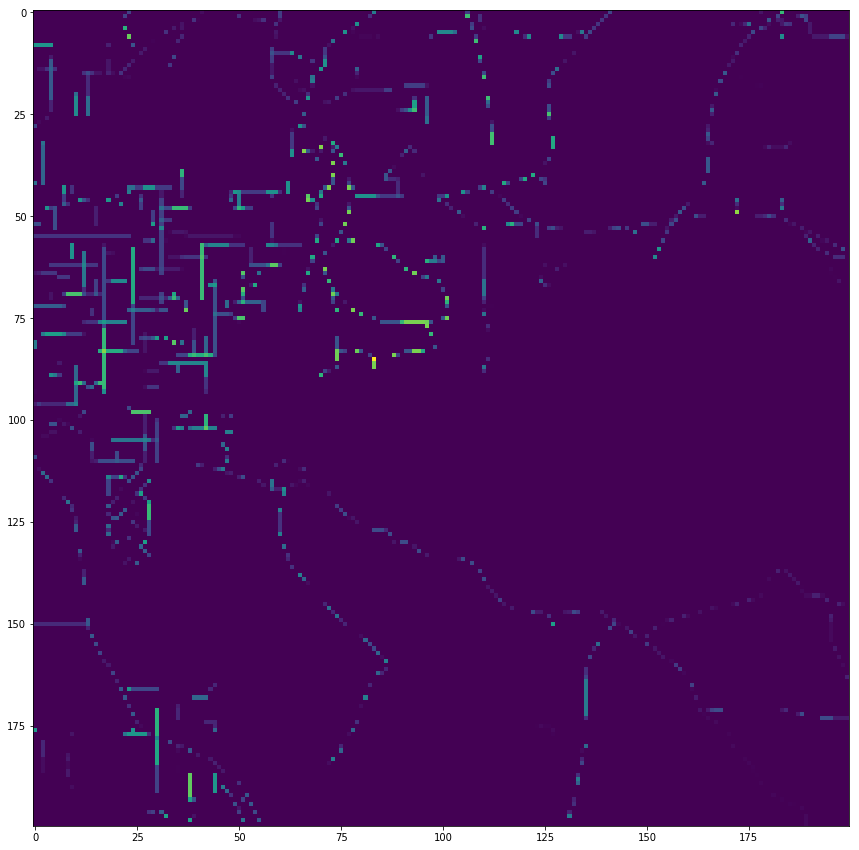

In [22]:
# visualize graphs.    
plt.figure(figsize = (15,15))
plt.imshow(image_array[0, 0, :, :])

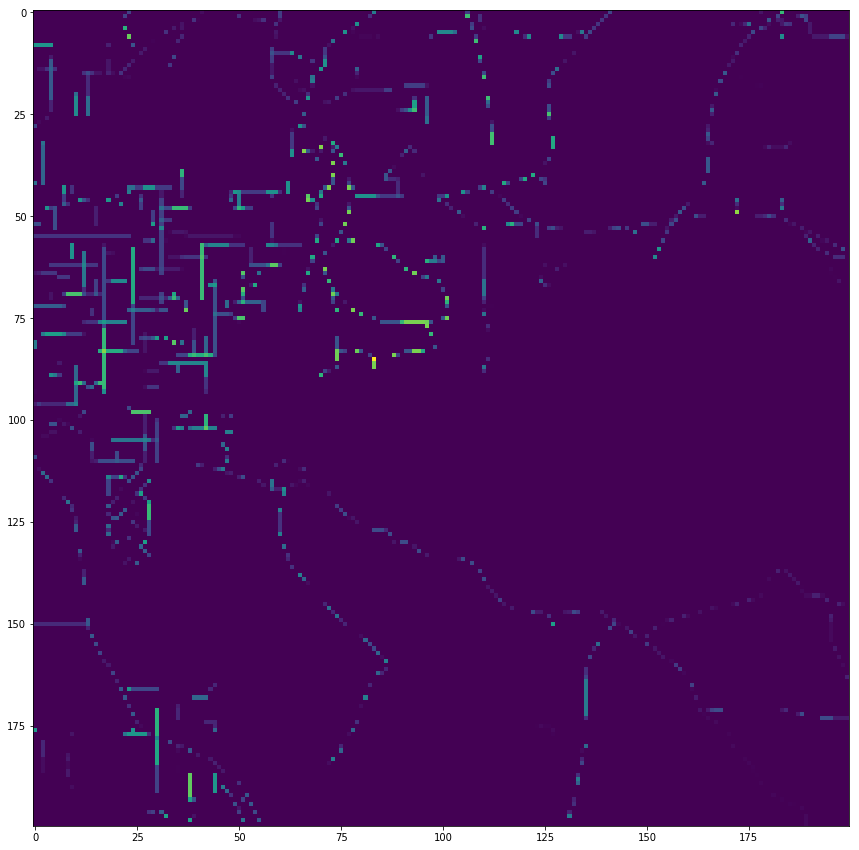

In [23]:
plt.figure(figsize = (15,15))
plt.imshow(image_array[1, 0, :, :])

In [28]:
print("NHTS and Image data match: ", df_intersect.shape[0] == image_array.shape[0])
print(image_array.shape)
print(df_intersect.shape,"nhts")
np.save("image_array", image_array)

NHTS and Image data match:  True
(4445, 4, 200, 200)
(4445, 261) nhts


In [29]:
df_intersect.head()

,CDIVMSAR,CENSUS_D,CENSUS_R,DRIVER,DRVRCNT,ENDTIME,EDUC,GASPRICE,HBHTNRNT,HBHUR,...,PTRANS_AGREE,SPHONE_HIGH,TAB_HIGH,TAXI_HIGH,WALK_HIGH,WALK2SAVE_AGREE,WEBUSE17_HIGH,HHCNTYFP,HHCT,CENSUS_ID
0,74,0.002087,0.000894,0.000298,0.000596,700,0.000596,207.9,0.011925,T,...,0,1,1,0,0,0,1,059,020400,05059020400
1,74,0.002087,0.000894,0.000298,0.000596,800,0.000596,207.9,0.011925,T,...,0,1,1,0,0,0,1,059,020400,05059020400
2,74,0.002087,0.000894,0.000298,0.000596,930,0.000596,207.9,0.011925,T,...,0,1,1,0,0,0,1,059,020400,05059020400
3,74,0.002087,0.000894,0.000298,0.000596,1115,0.000596,207.9,0.011925,T,...,0,1,1,0,0,0,1,059,020400,05059020400
4,74,0.002087,0.000894,0.000298,0.000596,1230,0.000596,207.9,0.011925,T,...,0,1,1,0,0,0,1,059,020400,05059020400


In [30]:
df_intersect.to_csv("df_intersection")

In [31]:
### divide the datasets into x_train_nhts, x_train_images, x_test_nhts, x_test_images, y_train, y_test.
n_train = df_intersect.shape[0]
shuffle_idx = np.arange(n_train)
np.random.shuffle(shuffle_idx)
train_ratio = 0.8
### TO-DO: Whenevern I start shuffling with (900, 900) image size, I exhaust the memory of my laptop...Need to solve the problem.
x_train_nhts = df_intersect.loc[shuffle_idx[:int(train_ratio*n_train)], input_var_short].values
x_train_images = image_array[shuffle_idx[:int(train_ratio*n_train)], :, :, :] 
x_test_nhts = df_intersect.loc[shuffle_idx[int(train_ratio*n_train):], input_var_short].values
x_test_images = image_array[shuffle_idx[int(train_ratio*n_train):], :, :, :]
y_train = df_intersect.loc[shuffle_idx[:int(train_ratio*n_train)], output_var].values
y_test = df_intersect.loc[shuffle_idx[int(train_ratio*n_train):], output_var].values

print("The sample size of training set is: ", x_train_nhts.shape[0])
print("The sample size of testing set is: ", x_test_nhts.shape[0])

The sample size of training set is:  3556
The sample size of testing set is:  889


In [32]:
# for elt, eltstr in [() , (x_train_images,"x_train_images"), (x_test_nhts,"x_test_nhts"), (x_test_images,"x_test_images"), (y_train,"y_train"), (y_test,"y_test")]:
#     np.save(eltstr, elt)

In [33]:
np.save("x_train_nhts", x_train_nhts)

In [34]:
np.save("x_train_images",x_train_images)

In [35]:
np.save("x_test_images",x_test_images)

In [36]:
np.save("y_train",y_train)

In [37]:
np.save("y_test",y_test)

In [38]:

np.save("x_test_nhts", x_test_nhts)